In [1]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

В мире современных социальных сетей важно не просто наполнять ленты контентом, но и
связывать его с интересами пользователей, находя взаимосвязи между постами. Грамотно
настроенный механизм сопоставления контента улучшает персональные рекомендации,
что повышает вовлечённость пользователей и обогащает их опыт.

В рамках данного соревнования вам предстоит разработать модель, которая определит,
насколько два поста близки по смыслу и релевантны друг другу. Это могут быть не только
схожие публикации, но и те, которые частично совпадают по содержанию, затрагивают
одну тему под разными углами или вовсе не связаны между собой.

Данные

Задача состоит в том, чтобы на основании заголовка и текста постов классифицировать
пары по одной из категорий, для которых степень релевантности выглядит следующим
образом:
```
relevant_plus > relevant > relevant_minus > no_relevant
```

# Load Data

In [2]:
! gdown --fuzzy "https://drive.google.com/file/d/1chUogO-RDrwu8CRSmK_qqGoR-IcCgwlv/view?usp=drive_link"
! unzip -q dzen.zip

Downloading...
From (original): https://drive.google.com/uc?id=1chUogO-RDrwu8CRSmK_qqGoR-IcCgwlv
From (redirected): https://drive.google.com/uc?id=1chUogO-RDrwu8CRSmK_qqGoR-IcCgwlv&confirm=t&uuid=d5724a7e-9ac3-4fa1-9ed1-b892b64002fd
To: /content/dzen.zip
100% 672M/672M [00:09<00:00, 70.5MB/s]


In [3]:
import pandas as pd

df = pd.read_parquet("items.parquet")
df.head()

,authorId,content,itemId,title
0,22062724202903043,Британский кот — олицетворение невозмутимости....,1155255918526217609,"Как воспитать британского кота добрым, ласковы..."
1,5021973993129217102,Комнатные растения можно встретить в квартирах...,3466678402942852201,Вызывают судороги и смерть: пять опасных комна...
2,5843309594367696221,КОНТЕЙНЕР И БЫТОВКА Бывший в употреблении морс...,9802178366207388656,Из чего построить дачный дом? Семь доступных в...
3,4785891415385376217,Советский разведчик Аркадий Корнев с гранатой ...,5959787242217250844,Как осажденные советские солдаты в Афганистане...
4,6405657875686126019,Преимущества и недостатки оснастки и техники...,14212405135790401725,Преимущества и недостатки оснастки и техники д...


In [4]:
from textwrap import fill
print(fill(df.iloc[2].to_dict()["content"], 90))

КОНТЕЙНЕР И БЫТОВКА Бывший в употреблении морской контейнер можно купить в интернете от
100 000 рублей.   Проектов переделки в жилище там же, в сети, великое множество. Особенно
впечатляют постройки из двух-трех контейнеров с витражным остеклением. Особым обаянием
такие дома наделяет большая открытая веранда. Металлический каркас и обшивка у них очень
прочные, рассчитаны на то, чтобы их ставить друг на друга, поэтому и вы можете собрать
себе двухуровневый дом.   Поставить на фундамент, утеплить, обшить снаружи сайдингом или
деревом. Получится не просто домик для инвентаря, а полноценный загородный дом, такой
эффектный, что никто не догадается, из чего он сделан. В таком доме можно жить не только в
дачный сезон, но и круглый год. КУНГ КУНГ – Кузов Унифицированный Нормального (Нулевого)
Габарита. В послевоенные годы эти металлические кузова стали очень популярны благодаря
своему удобству, а аббревиатура кунг стала нарицательной. Эконом-вариант, если контейнер
не по карману. Его, конечно,

In [5]:
tr = pd.read_csv("train.csv")
tr.head()

,leftItemId,rightItemId,target
0,8456188648456666255,17842617327504664637,relevant_minus
1,2587705644018673303,4730919752548875048,relevant_minus
2,14440570074797857092,9007102992088629866,relevant
3,10768915202093280757,8382562539112058142,relevant
4,2799154957886243971,11333177839206244806,no_relevant


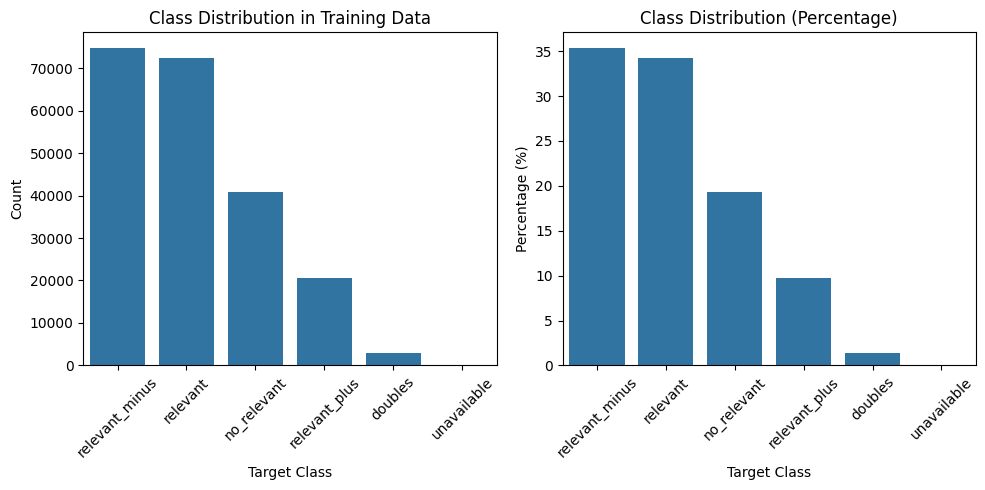

Class counts:
target
relevant_minus    74697
relevant          72436
no_relevant       40890
relevant_plus     20471
doubles            2809
unavailable          90
Name: count, dtype: int64

Class percentages:
target
relevant_minus    35.335607
relevant          34.266035
no_relevant       19.343119
relevant_plus      9.683859
doubles            1.328805
unavailable        0.042575
Name: proportion, dtype: float64


In [6]:
# Class balance analysis
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

# Count plot
plt.subplot(1, 2, 1)
class_counts = tr['target'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution in Training Data')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Percentage plot
plt.subplot(1, 2, 2)
class_percentages = tr['target'].value_counts(normalize=True) * 100
sns.barplot(x=class_percentages.index, y=class_percentages.values)
plt.title('Class Distribution (Percentage)')
plt.xlabel('Target Class')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("Class counts:")
print(class_counts)
print("\nClass percentages:")
print(class_percentages)


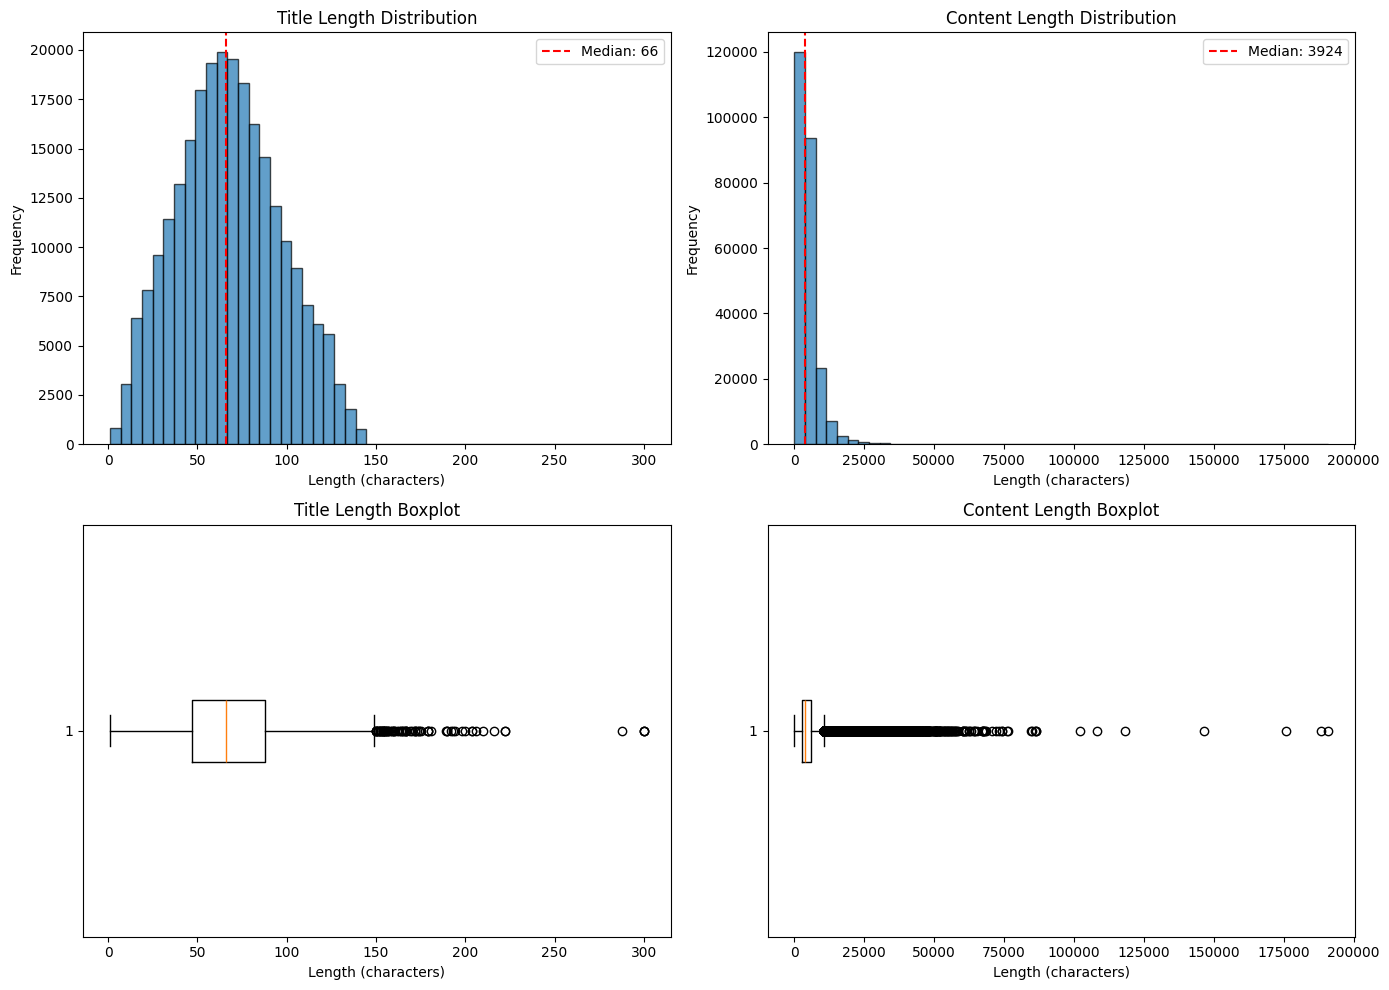

Title length statistics:
count    249451.000000
mean         67.611559
std          29.264921
min           1.000000
25%          47.000000
50%          66.000000
75%          88.000000
max         300.000000
Name: title_length, dtype: float64

Content length statistics:
count    249451.000000
mean       4901.929990
std        3925.057784
min           0.000000
25%        2665.000000
50%        3924.000000
75%        5907.000000
max      190967.000000
Name: content_length, dtype: float64


In [7]:
# Length distributions
df['title_length'] = df['title'].str.len()
df['content_length'] = df['content'].str.len()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Title length distribution
axes[0, 0].hist(df['title_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Title Length Distribution')
axes[0, 0].set_xlabel('Length (characters)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['title_length'].median(), color='red', linestyle='--', label=f'Median: {df["title_length"].median():.0f}')
axes[0, 0].legend()

# Content length distribution
axes[0, 1].hist(df['content_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Content Length Distribution')
axes[0, 1].set_xlabel('Length (characters)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df['content_length'].median(), color='red', linestyle='--', label=f'Median: {df["content_length"].median():.0f}')
axes[0, 1].legend()

# Title length boxplot
axes[1, 0].boxplot(df['title_length'], vert=False)
axes[1, 0].set_title('Title Length Boxplot')
axes[1, 0].set_xlabel('Length (characters)')

# Content length boxplot
axes[1, 1].boxplot(df['content_length'], vert=False)
axes[1, 1].set_title('Content Length Boxplot')
axes[1, 1].set_xlabel('Length (characters)')

plt.tight_layout()
plt.show()

print("Title length statistics:")
print(df['title_length'].describe())
print("\nContent length statistics:")
print(df['content_length'].describe())


In [8]:
# Item ID usage analysis
all_items = set(df['itemId'])
train_left_items = set(tr['leftItemId'])
train_right_items = set(tr['rightItemId'])
train_all_items = train_left_items | train_right_items

print(f"Total unique items in items.parquet: {len(all_items)}")
print(f"Unique items used in train (left): {len(train_left_items)}")
print(f"Unique items used in train (right): {len(train_right_items)}")
print(f"Unique items used in train (total): {len(train_all_items)}")
print(f"\nPercentage of items used in train: {len(train_all_items) / len(all_items) * 100:.2f}%")

# Check if there are items in train not in the items dataframe
items_in_train_not_in_df = train_all_items - all_items
print(f"\nItems in train not in items.parquet: {len(items_in_train_not_in_df)}")

# Check if there are items in df not used in train
items_not_used_in_train = all_items - train_all_items
print(f"Items in items.parquet not used in train: {len(items_not_used_in_train)}")


Total unique items in items.parquet: 249451
Unique items used in train (left): 120672
Unique items used in train (right): 138518
Unique items used in train (total): 216727

Percentage of items used in train: 86.88%

Items in train not in items.parquet: 0
Items in items.parquet not used in train: 32724


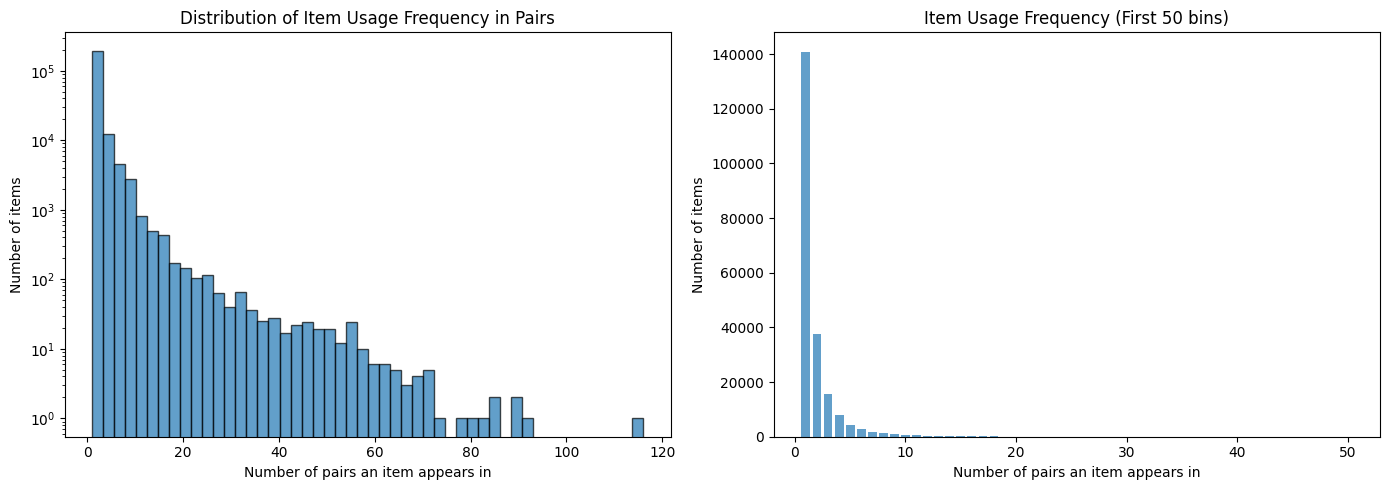

Minimum pairs per item: 1
Maximum pairs per item: 116
Mean pairs per item: 1.95
Median pairs per item: 1

Top 10 most frequently used items:
  Item 882952391163033740: appears in 116 pairs
  Item 3168819328759261068: appears in 91 pairs
  Item 12183802200932061205: appears in 90 pairs
  Item 3603716161414212099: appears in 89 pairs
  Item 11811609427722947261: appears in 86 pairs
  Item 11755758589059506681: appears in 85 pairs
  Item 6353350393004414828: appears in 82 pairs
  Item 12642797452497129729: appears in 81 pairs
  Item 14801167392792165352: appears in 77 pairs
  Item 3462976363215836717: appears in 73 pairs


In [9]:
# Item ID frequency in pairs
from collections import Counter

# Count occurrences of each item in train pairs
left_counts = Counter(tr['leftItemId'])
right_counts = Counter(tr['rightItemId'])

# Combine counts
all_counts = Counter()
for item_id in train_all_items:
    all_counts[item_id] = left_counts.get(item_id, 0) + right_counts.get(item_id, 0)

# Analyze frequency distribution
frequency_values = list(all_counts.values())

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(frequency_values, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Item Usage Frequency in Pairs')
plt.xlabel('Number of pairs an item appears in')
plt.ylabel('Number of items')
plt.yscale('log')

plt.subplot(1, 2, 2)
freq_dist = Counter(frequency_values)
top_freqs = sorted(freq_dist.items(), key=lambda x: x[0])[:50]  # Show first 50 frequency bins
plt.bar([x[0] for x in top_freqs], [x[1] for x in top_freqs], alpha=0.7)
plt.title('Item Usage Frequency (First 50 bins)')
plt.xlabel('Number of pairs an item appears in')
plt.ylabel('Number of items')

plt.tight_layout()
plt.show()

print(f"Minimum pairs per item: {min(frequency_values)}")
print(f"Maximum pairs per item: {max(frequency_values)}")
print(f"Mean pairs per item: {sum(frequency_values) / len(frequency_values):.2f}")
print(f"Median pairs per item: {sorted(frequency_values)[len(frequency_values)//2]}")

# Show top 10 most frequently used items
most_common = all_counts.most_common(10)
print("\nTop 10 most frequently used items:")
for item_id, count in most_common:
    print(f"  Item {item_id}: appears in {count} pairs")


In [10]:
# Load and analyze test data
import os

if os.path.exists('test.csv'):
    test = pd.read_csv('test.csv')
    print(f"Test data shape: {test.shape}")
    print("\nTest data head:")
    print(test.head())

    # Check test item IDs
    test_left_items = set(test['leftItemId'])
    test_right_items = set(test['rightItemId'])
    test_all_items = test_left_items | test_right_items

    print(f"\nUnique items in test (left): {len(test_left_items)}")
    print(f"Unique items in test (right): {len(test_right_items)}")
    print(f"Unique items in test (total): {len(test_all_items)}")

    # Overlap between train and test
    train_test_overlap = train_all_items & test_all_items
    print(f"\nItems appearing in both train and test: {len(train_test_overlap)}")
    print(f"Percentage of test items seen in train: {len(train_test_overlap) / len(test_all_items) * 100:.2f}%")

    # Items only in test
    only_in_test = test_all_items - train_all_items
    print(f"Items only in test (not in train): {len(only_in_test)}")
else:
    print("test.csv not found in current directory")


Test data shape: (51636, 2)

Test data head:
             leftItemId           rightItemId
0  15923600479346774213  10591191871885021601
1   7866768712250438268   9584895322191308561
2   6742770626780529612   6966853603787522235
3   4113267524593114411  16868459055811063062
4  18183962070656736836  17204657866960404813

Unique items in test (left): 39826
Unique items in test (right): 44123
Unique items in test (total): 76974

Items appearing in both train and test: 44250
Percentage of test items seen in train: 57.49%
Items only in test (not in train): 32724


In [11]:
# Inspect posts with content length > 25k characters
long_content_threshold = 25000
long_posts = df[df['content_length'] > long_content_threshold]

print(f"Posts with content length > {long_content_threshold} chars: {len(long_posts)}")
print(f"Percentage of total posts: {len(long_posts) / len(df) * 100:.2f}%\n")

left = 5

if len(long_posts) > 0:
    print("Statistics for long posts:")
    print(long_posts['content_length'].describe())
    print("\n" + "="*80 + "\n")

    # Show details for each long post
    for idx, row in long_posts.iterrows():
        if left == 0:
            break
        print(f"Post #{idx}")
        print(f"  Item ID: {row['itemId']}")
        print(f"  Author ID: {row['authorId']}")
        print(f"  Title length: {row['title_length']} chars")
        print(f"  Content length: {row['content_length']} chars")
        print(f"  Title: {row['title'][:100]}{'...' if len(row['title']) > 100 else ''}")
        print("  Content preview (first 200 chars):")
        print(f"    {row['content'][:200]}...")
        print("  Content preview (last 200 chars):")
        print(f"    ...{row['content'][-200:]}")

        # Check if this item is used in train/test
        in_train = row['itemId'] in train_all_items
        in_test = row['itemId'] in test_all_items if 'test_all_items' in locals() else False
        print(f"  Used in train: {in_train}")
        if in_train:
            print(f"    Appears in {all_counts[row['itemId']]} pairs")
        print(f"  Used in test: {in_test}")
        print("\n" + "="*80 + "\n")
        left -= 1

else:
    print("No posts with content length exceeding the threshold.")


Posts with content length > 25000 chars: 1172
Percentage of total posts: 0.47%

Statistics for long posts:
count      1172.000000
mean      34723.981229
std       13165.434449
min       25003.000000
25%       27432.250000
50%       31431.500000
75%       37616.500000
max      190967.000000
Name: content_length, dtype: float64


Post #86
  Item ID: 7203286587683239892
  Author ID: 9813851710505140936
  Title length: 78 chars
  Content length: 39413 chars
  Title: Военный эксперт Жилин: «СВО начинает стучаться в двери и окна каждой квартиры»
  Content preview (first 200 chars):
    Почему депутаты и чиновники не шагают в первых рядах мобилизации и как не платить ипотеку тем, кто сражается за Родину «Я еще в феврале предупреждал, что мы можем угодить в ловушку на востоке Украины,...
  Content preview (last 200 chars):
    ...ладимира Владимировича, потому что вопрос встанет о судьбе их детей, внуков и правнуков. И все, что им вдули в головы телевизионные Скабеевы и Соловьевы про «разбомби

In [12]:
# Inspect posts that appear in pairs more than 50 times
frequency_threshold = 50
frequent_items = {item_id: count for item_id, count in all_counts.items() if count > frequency_threshold}

print(f"Posts appearing in > {frequency_threshold} pairs: {len(frequent_items)}")
print(f"Percentage of items used in train: {len(frequent_items) / len(train_all_items) * 100:.2f}%\n")

if len(frequent_items) > 0:
    # Sort by frequency (descending)
    sorted_frequent = sorted(frequent_items.items(), key=lambda x: x[1], reverse=True)

    print("Distribution of these frequent items:")
    frequencies = list(frequent_items.values())
    print(f"  Min frequency: {min(frequencies)}")
    print(f"  Max frequency: {max(frequencies)}")
    print(f"  Mean frequency: {sum(frequencies) / len(frequencies):.2f}")
    print(f"  Median frequency: {sorted(frequencies)[len(frequencies)//2]}")
    print("\n" + "="*80 + "\n")

    # Show details for top frequent items
    for item_id, count in sorted_frequent[:3]:  # Show top 3
        # Get post details from df
        post_data = df[df['itemId'] == item_id]

        if len(post_data) > 0:
            post = post_data.iloc[0]
            print(f"Item ID: {item_id}")
            print(f"  Appears in {count} pairs")
            print(f"  Author ID: {post['authorId']}")
            print(f"  Title: {post['title']}")
            print(f"  Title length: {post['title_length']} chars")
            print(f"  Content length: {post['content_length']} chars")
            print("  Content preview (first 300 chars):")
            print(f"    {post['content'][:300]}...")

            # Analyze what relevance classes this item appears in
            left_pairs = tr[tr['leftItemId'] == item_id]
            right_pairs = tr[tr['rightItemId'] == item_id]
            all_pairs = pd.concat([left_pairs, right_pairs])

            print("\n  Relevance distribution for this item:")
            target_dist = all_pairs['target'].value_counts()
            for target, target_count in target_dist.items():
                print(f"    {target}: {target_count} ({target_count/len(all_pairs)*100:.1f}%)")

            print("\n" + "="*80 + "\n")
        else:
            print(f"Item ID {item_id}: appears in {count} pairs (NOT FOUND in items.parquet!)")
            print("="*80 + "\n")

        left

    if len(sorted_frequent) > 3:
        print(f"... and {len(sorted_frequent) - 3} more frequent items")
else:
    print("No posts appear in more than the threshold number of pairs.")


Posts appearing in > 50 pairs: 95
Percentage of items used in train: 0.04%

Distribution of these frequent items:
  Min frequency: 51
  Max frequency: 116
  Mean frequency: 60.93
  Median frequency: 57


Item ID: 882952391163033740
  Appears in 116 pairs
  Author ID: 10614842300977517960
  Title: Блеск и ужас встречи Нового года в поезде на Петрозаводск
  Title length: 57 chars
  Content length: 10998 chars
  Content preview (first 300 chars):
    Идея поехать с семьей в путешествие поездом именно в новогоднюю ночь возникла давно. Но были и сомнения – ехать ли вообще и куда именно. В итоге выбор пал на Карелию. Веселье, лабрадор с котами, новогодний вагон-ресторан, беспокойные соседи и красивые паровозы – все это ожидало нас в поездке.  Напом...

  Relevance distribution for this item:
    no_relevant: 101 (87.1%)
    relevant_minus: 11 (9.5%)
    relevant: 4 (3.4%)


Item ID: 3168819328759261068
  Appears in 91 pairs
  Author ID: 9963866769051969857
  Title: Beluga Caviar Bar Шереметь

Total unique authors: 7762
Total posts: 249451
Average posts per author: 32.14

Posts per author statistics:
count    7762.000000
mean       32.137465
std        81.890027
min         1.000000
25%         1.000000
50%         5.000000
75%        23.000000
max      1589.000000
Name: count, dtype: float64



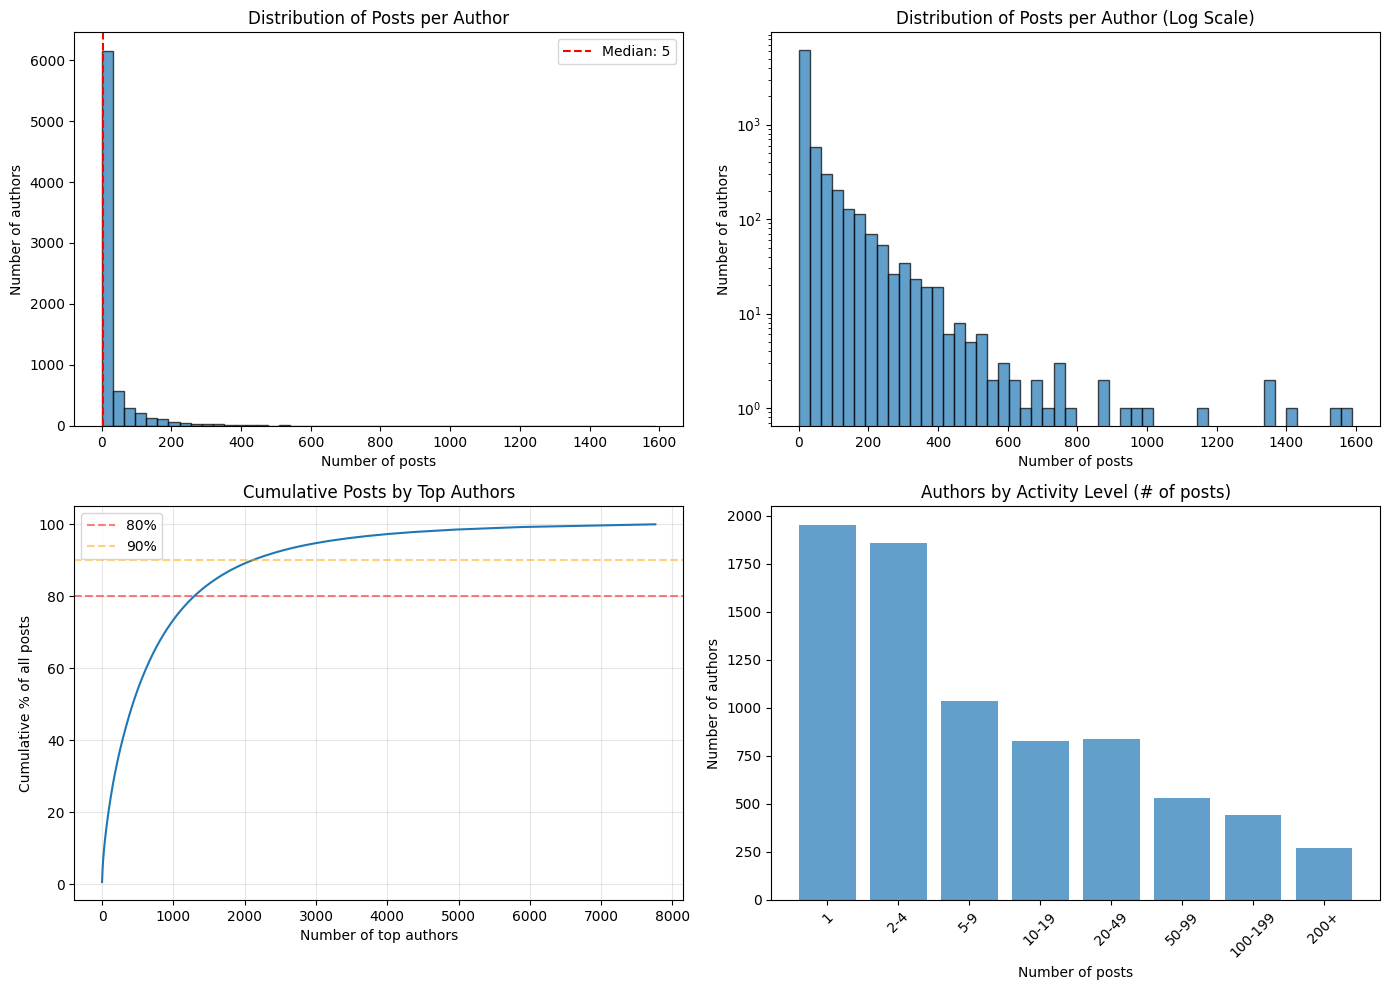


Percentiles of posts per author:
  10th percentile: 1 posts
  25th percentile: 1 posts
  50th percentile: 5 posts
  75th percentile: 23 posts
  90th percentile: 90 posts
  95th percentile: 165 posts
  99th percentile: 368 posts

Top 1292 authors (16.6%) account for 80% of all posts
Top 2108 authors (27.2%) account for 90% of all posts


In [13]:
# Author analysis

# Count unique authors
unique_authors = df['authorId'].nunique()
total_posts = len(df)

print(f"Total unique authors: {unique_authors}")
print(f"Total posts: {total_posts}")
print(f"Average posts per author: {total_posts / unique_authors:.2f}\n")

# Distribution of posts per author
posts_per_author = df['authorId'].value_counts()

print("Posts per author statistics:")
print(posts_per_author.describe())
print()

# Visualize distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram of posts per author
axes[0, 0].hist(posts_per_author.values, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Posts per Author')
axes[0, 0].set_xlabel('Number of posts')
axes[0, 0].set_ylabel('Number of authors')
axes[0, 0].axvline(posts_per_author.median(), color='red', linestyle='--',
                    label=f'Median: {posts_per_author.median():.0f}')
axes[0, 0].legend()

# Log scale histogram
axes[0, 1].hist(posts_per_author.values, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Posts per Author (Log Scale)')
axes[0, 1].set_xlabel('Number of posts')
axes[0, 1].set_ylabel('Number of authors')
axes[0, 1].set_yscale('log')

# Cumulative distribution
sorted_posts = sorted(posts_per_author.values, reverse=True)
cumulative_posts = [sum(sorted_posts[:i+1]) for i in range(len(sorted_posts))]
cumulative_pct = [cp / total_posts * 100 for cp in cumulative_posts]
axes[1, 0].plot(range(len(cumulative_pct)), cumulative_pct)
axes[1, 0].set_title('Cumulative Posts by Top Authors')
axes[1, 0].set_xlabel('Number of top authors')
axes[1, 0].set_ylabel('Cumulative % of all posts')
axes[1, 0].grid(True, alpha=0.3)
# Mark 80% and 90% lines
axes[1, 0].axhline(80, color='red', linestyle='--', alpha=0.5, label='80%')
axes[1, 0].axhline(90, color='orange', linestyle='--', alpha=0.5, label='90%')
axes[1, 0].legend()

# Distribution of author activity levels
activity_bins = [1, 2, 5, 10, 20, 50, 100, 200, float('inf')]
activity_labels = ['1', '2-4', '5-9', '10-19', '20-49', '50-99', '100-199', '200+']
activity_counts = pd.cut(posts_per_author.values, bins=activity_bins, labels=activity_labels, right=False)
activity_dist = activity_counts.value_counts().sort_index()
axes[1, 1].bar(range(len(activity_dist)), activity_dist.values, alpha=0.7)
axes[1, 1].set_xticks(range(len(activity_dist)))
axes[1, 1].set_xticklabels(activity_dist.index, rotation=45)
axes[1, 1].set_title('Authors by Activity Level (# of posts)')
axes[1, 1].set_xlabel('Number of posts')
axes[1, 1].set_ylabel('Number of authors')

plt.tight_layout()
plt.show()

# Show percentiles
print("\nPercentiles of posts per author:")
percentiles = [10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    value = posts_per_author.quantile(p / 100)
    print(f"  {p}th percentile: {value:.0f} posts")

# Find how many authors account for 80% and 90% of posts
posts_80 = total_posts * 0.8
posts_90 = total_posts * 0.9
authors_80 = next(i+1 for i, cp in enumerate(cumulative_posts) if cp >= posts_80)
authors_90 = next(i+1 for i, cp in enumerate(cumulative_posts) if cp >= posts_90)

print(f"\nTop {authors_80} authors ({authors_80/unique_authors*100:.1f}%) account for 80% of all posts")
print(f"Top {authors_90} authors ({authors_90/unique_authors*100:.1f}%) account for 90% of all posts")


In [14]:
# Top authors details
print("Top 20 most prolific authors:\n")
print("="*80)

top_authors = posts_per_author.head(20)

for rank, (author_id, post_count) in enumerate(top_authors.items(), 1):
    author_posts = df[df['authorId'] == author_id]

    # Get some sample titles from this author
    sample_titles = author_posts['title'].head(3).tolist()

    # Check if any of this author's posts are in train
    author_items = set(author_posts['itemId'])
    items_in_train = author_items & train_all_items
    items_in_test = author_items & test_all_items if 'test_all_items' in locals() else set()

    print(f"{rank}. Author ID: {author_id}")
    print(f"   Posts: {post_count}")
    print(f"   Items in train: {len(items_in_train)} ({len(items_in_train)/post_count*100:.1f}%)")
    print(f"   Items in test: {len(items_in_test)} ({len(items_in_test)/post_count*100:.1f}%)")
    print(f"   Avg title length: {author_posts['title_length'].mean():.1f} chars")
    print(f"   Avg content length: {author_posts['content_length'].mean():.1f} chars")
    print("   Sample titles:")
    for i, title in enumerate(sample_titles, 1):
        print(f"     {i}. {title[:80]}{'...' if len(title) > 80 else ''}")
    print("="*80)


Top 20 most prolific authors:

1. Author ID: 11120158660896222880
   Posts: 1589
   Items in train: 1381 (86.9%)
   Items in test: 546 (34.4%)
   Avg title length: 68.1 chars
   Avg content length: 4665.9 chars
   Sample titles:
     1. «Дело Борисенко»: тайная исчезновения сына лидера советской Украины
     2. За что восточные ассасины приговорили Сталина к смерти
     3. Борис Пивенштейн: почему летчика, спасавшего челюскинцев, приговорили к смертной...
2. Author ID: 2352176866398567323
   Posts: 1539
   Items in train: 1305 (84.8%)
   Items in test: 461 (30.0%)
   Avg title length: 71.4 chars
   Avg content length: 5645.1 chars
   Sample titles:
     1. Семерка ненавистных: кого из российских звезд люди откровенно невзлюбили
     2. Учёные доказали, что дата нашего рождения влияет на здоровье
     3. Вагон прибыл без пассажиров: реальная история пропажи русских девушек
3. Author ID: 14145917242603071552
   Posts: 1406
   Items in train: 1259 (89.5%)
   Items in test: 539 (38.3%)
   

In [15]:
# Find closest author pairs based on post relevance

# First, create a mapping from itemId to authorId
item_to_author = df.set_index('itemId')['authorId'].to_dict()

# Add author information to train data
tr_with_authors = tr.copy()
tr_with_authors['leftAuthorId'] = tr_with_authors['leftItemId'].map(item_to_author)
tr_with_authors['rightAuthorId'] = tr_with_authors['rightItemId'].map(item_to_author)

# Remove rows where we couldn't find author info
tr_with_authors = tr_with_authors.dropna(subset=['leftAuthorId', 'rightAuthorId'])

print(f"Total pairs with author info: {len(tr_with_authors)}")
print(f"Pairs dropped due to missing author info: {len(tr) - len(tr_with_authors)}\n")

# Map target values to scores
relevance_scores = {
    'relevant_plus': 2,
    'relevant': 1,
    'relevant_minus': 0,
    'no_relevant': 0
}

tr_with_authors['relevance_score'] = tr_with_authors['target'].map(relevance_scores)

# Create canonical author pairs (ensure author1 <= author2 to avoid duplicates)
tr_with_authors['author_pair'] = tr_with_authors.apply(
    lambda row: tuple(sorted([row['leftAuthorId'], row['rightAuthorId']])),
    axis=1
)

# Group by author pairs and sum relevance scores
author_pair_scores = tr_with_authors.groupby('author_pair').agg({
    'relevance_score': 'sum',
    'target': 'count'  # number of pairs
}).rename(columns={'target': 'num_pairs'})

author_pair_scores = author_pair_scores.sort_values('relevance_score', ascending=False)

print(f"Total unique author pairs found: {len(author_pair_scores)}\n")
print("="*80)
print("Top 20 closest author pairs:\n")


Total pairs with author info: 211393
Pairs dropped due to missing author info: 0

Total unique author pairs found: 83262

Top 20 closest author pairs:



In [16]:
# Display details for top 20 author pairs
top_20_pairs = author_pair_scores.head(20)

for rank, ((author1, author2), row) in enumerate(top_20_pairs.iterrows(), 1):
    total_score = row['relevance_score']
    num_pairs = row['num_pairs']

    # Get posts from both authors
    author1_posts = df[df['authorId'] == author1]
    author2_posts = df[df['authorId'] == author2]

    # Get their pairs and relevance breakdown
    pair_mask = (
        ((tr_with_authors['leftAuthorId'] == author1) & (tr_with_authors['rightAuthorId'] == author2)) |
        ((tr_with_authors['leftAuthorId'] == author2) & (tr_with_authors['rightAuthorId'] == author1))
    )
    their_pairs = tr_with_authors[pair_mask]

    # Relevance distribution
    relevance_dist = their_pairs['target'].value_counts()

    print(f"{rank}. Author {author1} <-> Author {author2}")
    print(f"   Total relevance score: {total_score}")
    print(f"   Number of post pairs: {num_pairs}")
    print(f"   Average score per pair: {total_score / num_pairs:.2f}")
    print("   ")
    print("   Relevance breakdown:")
    for target in ['relevant_plus', 'relevant', 'relevant_minus', 'no_relevant']:
        count = relevance_dist.get(target, 0)
        pct = count / num_pairs * 100 if num_pairs > 0 else 0
        print(f"     {target}: {count} ({pct:.1f}%)")

    print("   ")
    print("   Author {author1}: {len(author1_posts)} posts total")
    print("     Sample titles:")
    for title in author1_posts['title'].head(2):
        print(f"       - {title[:70]}{'...' if len(title) > 70 else ''}")

    print(f"   Author {author2}: {len(author2_posts)} posts total")
    print("     Sample titles:")
    for title in author2_posts['title'].head(2):
        print(f"       - {title[:70]}{'...' if len(title) > 70 else ''}")

    print("="*80)


1. Author 4355561532571848179 <-> Author 4355561532571848179
   Total relevance score: 1093.0
   Number of post pairs: 1285.0
   Average score per pair: 0.85
   
   Relevance breakdown:
     relevant_plus: 262 (20.4%)
     relevant: 569 (44.3%)
     relevant_minus: 343 (26.7%)
     no_relevant: 106 (8.2%)
   
   Author {author1}: {len(author1_posts)} posts total
     Sample titles:
       - Как можно предать старые туфли
       - Жениться надо вовремя
   Author 4355561532571848179: 1363 posts total
     Sample titles:
       - Как можно предать старые туфли
       - Жениться надо вовремя
2. Author 7515144987822784630 <-> Author 7515144987822784630
   Total relevance score: 603.0
   Number of post pairs: 450.0
   Average score per pair: 1.34
   
   Relevance breakdown:
     relevant_plus: 226 (50.2%)
     relevant: 151 (33.6%)
     relevant_minus: 49 (10.9%)
     no_relevant: 17 (3.8%)
   
   Author {author1}: {len(author1_posts)} posts total
     Sample titles:
       - 9 смешных комик

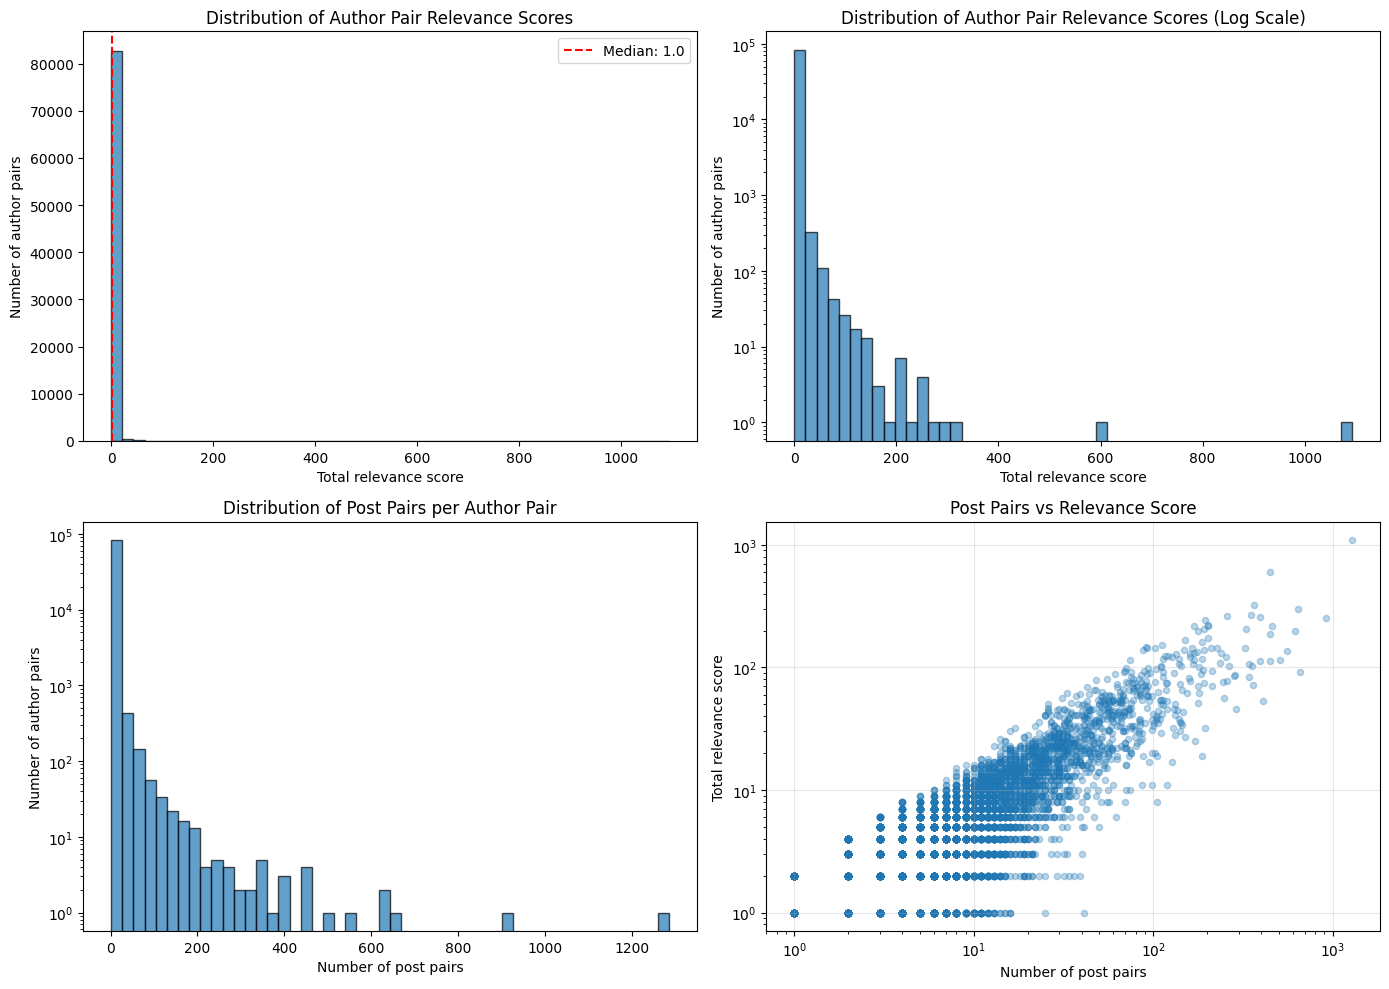

Author pair statistics:
  Total author pairs: 83262
  Mean relevance score: 1.36
  Median relevance score: 1.00
  Max relevance score: 1093
  Mean pairs per author pair: 2.54
  Median pairs per author pair: 1
  Max pairs per author pair: 1285

Author pairs with relevance score > 0: 41641 (50.0%)


In [17]:
# Visualize author pair proximity distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution of relevance scores
axes[0, 0].hist(author_pair_scores['relevance_score'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Author Pair Relevance Scores')
axes[0, 0].set_xlabel('Total relevance score')
axes[0, 0].set_ylabel('Number of author pairs')
axes[0, 0].axvline(author_pair_scores['relevance_score'].median(), color='red',
                    linestyle='--', label=f'Median: {author_pair_scores["relevance_score"].median():.1f}')
axes[0, 0].legend()

# Log scale
axes[0, 1].hist(author_pair_scores['relevance_score'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Author Pair Relevance Scores (Log Scale)')
axes[0, 1].set_xlabel('Total relevance score')
axes[0, 1].set_ylabel('Number of author pairs')
axes[0, 1].set_yscale('log')

# Distribution of number of pairs per author pair
axes[1, 0].hist(author_pair_scores['num_pairs'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribution of Post Pairs per Author Pair')
axes[1, 0].set_xlabel('Number of post pairs')
axes[1, 0].set_ylabel('Number of author pairs')
axes[1, 0].set_yscale('log')

# Scatter: num_pairs vs relevance_score
axes[1, 1].scatter(author_pair_scores['num_pairs'], author_pair_scores['relevance_score'],
                   alpha=0.3, s=20)
axes[1, 1].set_title('Post Pairs vs Relevance Score')
axes[1, 1].set_xlabel('Number of post pairs')
axes[1, 1].set_ylabel('Total relevance score')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Author pair statistics:")
print(f"  Total author pairs: {len(author_pair_scores)}")
print(f"  Mean relevance score: {author_pair_scores['relevance_score'].mean():.2f}")
print(f"  Median relevance score: {author_pair_scores['relevance_score'].median():.2f}")
print(f"  Max relevance score: {author_pair_scores['relevance_score'].max():.0f}")
print(f"  Mean pairs per author pair: {author_pair_scores['num_pairs'].mean():.2f}")
print(f"  Median pairs per author pair: {author_pair_scores['num_pairs'].median():.0f}")
print(f"  Max pairs per author pair: {author_pair_scores['num_pairs'].max():.0f}")

# Pairs with score > 0
positive_score_pairs = author_pair_scores[author_pair_scores['relevance_score'] > 0]
print(f"\nAuthor pairs with relevance score > 0: {len(positive_score_pairs)} ({len(positive_score_pairs)/len(author_pair_scores)*100:.1f}%)")


решение 1:
- сравнение только заголовков
- мультиномиальный логрег над конкатенацией эмбедингов из sentence transformers

решение 2:
- обучить свои sentence эмбединги на lstm
- брать последний hidden state как признаковое описание предложения
- обучать линейный слой классификации над конкатенацией двух эмбедингов

решение 3:
- использовать TextCNN (несколько сверток разных размеров + max pool + linear projection = эмбединг предложения)
- обучать линейный слой классификации над конкатенацией двух эмбедингов

решение 3:
- обучить w2v из gensim
- усреднение эмбедингов токенов = эмбединг предложения
- мультиномиальный логрег над конкатенацией эмбедингов

# Solutions

## Baseline Implementation

Baseline approach:
- Compare only titles
- Multinomial Logistic Regression with concatenated bi-encoder embeddings
- Model: multilingual-e5-large


In [18]:
# Step 1: Filter training data and create train/val split
from sklearn.model_selection import train_test_split

relevance_classes = ['relevant_plus', 'relevant', 'relevant_minus', 'no_relevant']
tr_filtered = tr[tr['target'].isin(relevance_classes)].copy()

print(f"Original training size: {len(tr)}")
print(f"Filtered training size: {len(tr_filtered)}")
print("\nClass distribution after filtering:")
print(tr_filtered['target'].value_counts())
print("\nClass distribution (%):")
print(tr_filtered['target'].value_counts(normalize=True) * 100)

# Create train/validation split (80/20)
train_df, val_df = train_test_split(
    tr_filtered,
    test_size=0.2,
    random_state=42,
    stratify=tr_filtered['target']  # Maintain class distribution
)

print(f"\n{'='*60}")
print("Train/Validation Split:")
print(f"  Train size: {len(train_df):,}")
print(f"  Validation size: {len(val_df):,}")
print("\nTrain class distribution:")
print(train_df['target'].value_counts())
print("\nValidation class distribution:")
print(val_df['target'].value_counts())


Original training size: 211393
Filtered training size: 208494

Class distribution after filtering:
target
relevant_minus    74697
relevant          72436
no_relevant       40890
relevant_plus     20471
Name: count, dtype: int64

Class distribution (%):
target
relevant_minus    35.826930
relevant          34.742487
no_relevant       19.612075
relevant_plus      9.818508
Name: proportion, dtype: float64

Train/Validation Split:
  Train size: 166,795
  Validation size: 41,699

Train class distribution:
target
relevant_minus    59757
relevant          57949
no_relevant       32712
relevant_plus     16377
Name: count, dtype: int64

Validation class distribution:
target
relevant_minus    14940
relevant          14487
no_relevant        8178
relevant_plus      4094
Name: count, dtype: int64


In [19]:
# Step 2: Load multilingual-e5-large model
from sentence_transformers import SentenceTransformer
import numpy as np
from tqdm.auto import tqdm

# Load model
print("Loading transformer model...")
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
print(f"Model loaded. Embedding dimension: {model.get_sentence_embedding_dimension()}")

# Prepare titles with E5 instruction prefix
# E5 models require "query: " or "passage: " prefix for optimal performance
df_with_prefix = df.copy()
df_with_prefix['title_with_prefix'] = 'passage: ' + df_with_prefix['title'].fillna('')

print(f"\nTotal items to encode: {len(df_with_prefix)}")


Loading transformer model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded. Embedding dimension: 384

Total items to encode: 249451


In [20]:
# Step 3: Encode all titles in batches
print("Encoding all titles...")
batch_size = 64

# Get all titles with E5 prefix
all_titles = df_with_prefix['title_with_prefix'].tolist()

# Encode in batches with progress bar
embeddings = model.encode(
    all_titles,
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True  # L2 normalization for better cosine similarity
)

# Create item_id to embedding mapping
item_to_embedding = dict(zip(df_with_prefix['itemId'], embeddings))

print("\nEncoding complete!")
print(f"Embedding shape: {embeddings.shape}")
print(f"Sample embedding (first 10 dims): {embeddings[0][:10]}")


Encoding all titles...


Batches:   0%|          | 0/3898 [00:00<?, ?it/s]


Encoding complete!
Embedding shape: (249451, 384)
Sample embedding (first 10 dims): [-0.02200377  0.07545944  0.02693717 -0.00660343  0.04436676  0.03414365
  0.09918915 -0.00702837 -0.09072135 -0.05618989]


In [21]:
# Step 4: Create training and validation features by concatenating embeddings
print("Creating training and validation features...")

def create_pair_features(left_ids, right_ids, item_to_emb):
    """Concatenate embeddings for item pairs"""
    features = []
    for left_id, right_id in tqdm(zip(left_ids, right_ids), total=len(left_ids)):
        left_emb = item_to_emb[left_id]
        right_emb = item_to_emb[right_id]
        # Concatenate embeddings
        pair_features = np.concatenate([left_emb, right_emb])
        features.append(pair_features)
    return np.array(features)

# Create training features
print("Processing training set...")
X_train = create_pair_features(
    train_df['leftItemId'].values,
    train_df['rightItemId'].values,
    item_to_embedding
)
y_train = train_df['target'].values

# Create validation features
print("Processing validation set...")
X_val = create_pair_features(
    val_df['leftItemId'].values,
    val_df['rightItemId'].values,
    item_to_embedding
)
y_val = val_df['target'].values

print(f"\nTraining features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Unique classes: {np.unique(y_train)}")


Creating training and validation features...
Processing training set...


  0%|          | 0/166795 [00:00<?, ?it/s]

Processing validation set...


  0%|          | 0/41699 [00:00<?, ?it/s]


Training features shape: (166795, 768)
Training labels shape: (166795,)
Validation features shape: (41699, 768)
Validation labels shape: (41699,)
Unique classes: ['no_relevant' 'relevant' 'relevant_minus' 'relevant_plus']


In [22]:
# Step 5: Train LogisticRegressionCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder

print("Training LogisticRegressionCV...")

# Encode labels to integers (required for LogisticRegressionCV)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

print("Class mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {i}: {class_name}")

# Train LogisticRegressionCV with cross-validation
clf = LogisticRegressionCV(
    Cs=10,  # Number of regularization values to try
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    solver='lbfgs',
    # max_iter=1000,
    n_jobs=-1,  # Use all CPU cores
    verbose=1,
    random_state=42
)

clf.fit(X_train, y_train_encoded)

print("\nTraining complete!")
print(f"Best C value: {clf.C_}")
print(f"Cross-validation scores shape: {clf.scores_[1].shape}")
print(f"Mean CV score: {clf.scores_[1].mean():.4f}")


Training LogisticRegressionCV...
Class mapping:
  0: no_relevant
  1: relevant
  2: relevant_minus
  3: relevant_plus


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished



Training complete!
Best C value: [0.04641589 0.04641589 0.04641589 0.04641589]
Cross-validation scores shape: (5, 10)
Mean CV score: 0.3953


Evaluating on validation set...

Validation Accuracy: 0.4059

Classification Report:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                precision    recall  f1-score   support

   no_relevant       0.00      0.00      0.00      8178
      relevant       0.41      0.55      0.47     14487
relevant_minus       0.41      0.60      0.48     14940
 relevant_plus       0.00      0.00      0.00      4094

      accuracy                           0.41     41699
     macro avg       0.20      0.29      0.24     41699
  weighted avg       0.29      0.41      0.34     41699



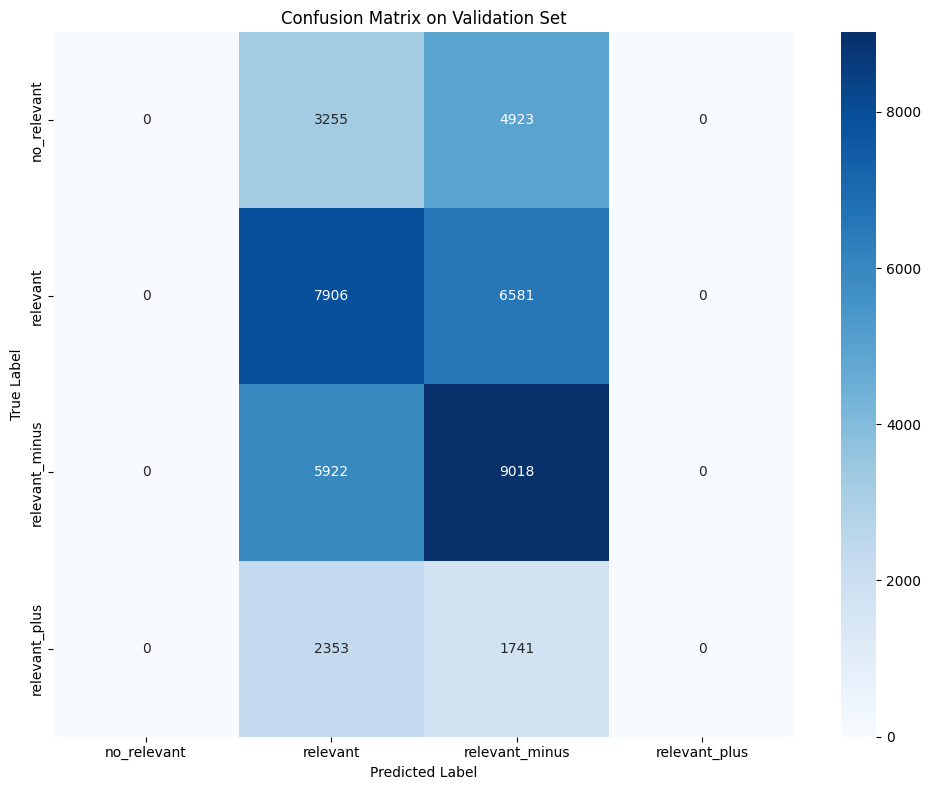

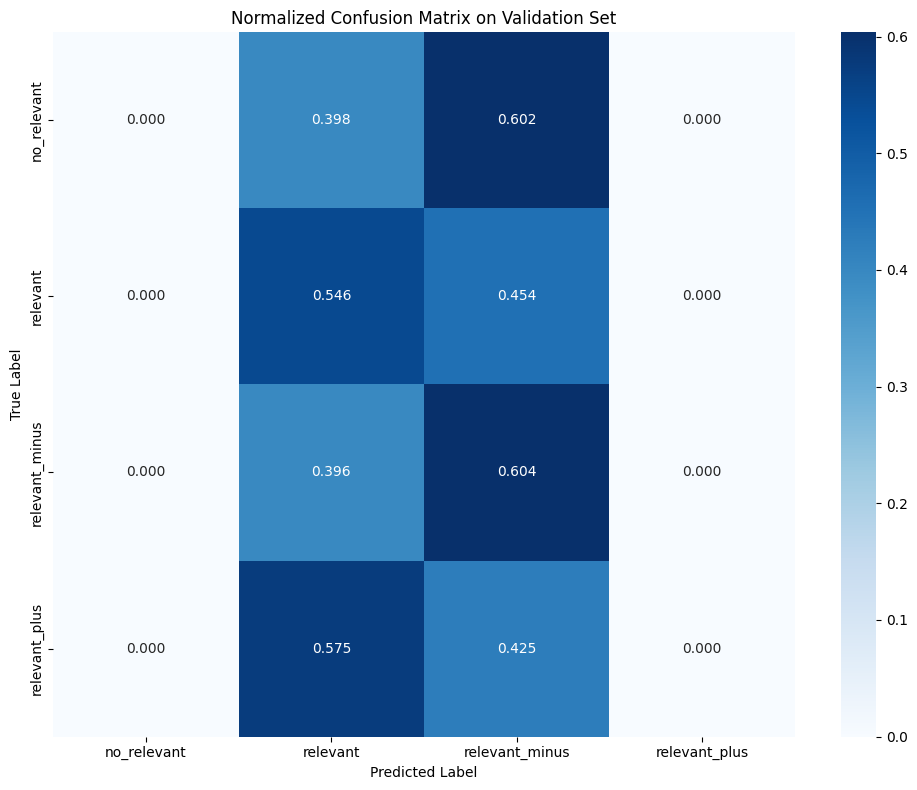

In [23]:
# Step 6: Evaluate on validation set
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

print("Evaluating on validation set...")

# Encode validation labels
y_val_encoded = label_encoder.transform(y_val)

# Predict on validation set
y_val_pred_encoded = clf.predict(X_val)
y_val_pred = label_encoder.inverse_transform(y_val_pred_encoded)

# Calculate accuracy
val_accuracy = accuracy_score(y_val_encoded, y_val_pred_encoded)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred, labels=label_encoder.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix on Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Normalized Confusion Matrix on Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


# Alternative Solutions

We will implement three additional approaches:
1. **LSTM Sentence Embeddings**: Train LSTM to encode sentences, use last hidden state
2. **TextCNN**: Multiple convolutions with different kernel sizes for sentence encoding
3. **Word2Vec + Averaging**: Train Word2Vec, average token embeddings

All approaches use a siamese architecture with concatenated embeddings.


## Data Preparation: Tokenization and Vocabulary


In [24]:
# Simple tokenizer for Russian text
import re
from collections import Counter

def simple_tokenize(text):
    """Simple tokenization: lowercase, remove punctuation, split"""
    if pd.isna(text):
        return []
    text = text.lower()
    # Keep only letters and spaces
    text = re.sub(r'[^а-яёa-z\s]', ' ', text)
    # Split and filter empty tokens
    tokens = [t for t in text.split() if t]
    return tokens

# Test tokenizer
sample_title = df.iloc[0]['title']
print(f"Original: {sample_title}")
print(f"Tokenized: {simple_tokenize(sample_title)}")


Original: Как воспитать британского кота добрым, ласковым и послушным
Tokenized: ['как', 'воспитать', 'британского', 'кота', 'добрым', 'ласковым', 'и', 'послушным']


In [25]:
# Build vocabulary from all titles
print("Tokenizing all titles...")
all_tokens = []
for title in tqdm(df['title'].fillna(''), desc="Tokenizing"):
    all_tokens.extend(simple_tokenize(title))

print(f"\nTotal tokens: {len(all_tokens)}")

# Count token frequencies
token_counts = Counter(all_tokens)
print(f"Unique tokens: {len(token_counts)}")

# Build vocabulary with minimum frequency
MIN_FREQ = 2
vocab = {'<PAD>': 0, '<UNK>': 1}  # Special tokens
for token, count in token_counts.items():
    if count >= MIN_FREQ:
        vocab[token] = len(vocab)

print(f"Vocabulary size (min_freq={MIN_FREQ}): {len(vocab)}")
print(f"Most common tokens: {token_counts.most_common(20)}")


Tokenizing all titles...


Tokenizing:   0%|          | 0/249451 [00:00<?, ?it/s]


Total tokens: 2465882
Unique tokens: 177668
Vocabulary size (min_freq=2): 91967
Most common tokens: [('и', 76202), ('в', 74811), ('на', 43998), ('как', 39606), ('не', 37895), ('с', 28295), ('что', 24771), ('из', 18822), ('для', 16368), ('почему', 15165), ('за', 14434), ('о', 13447), ('от', 13168), ('которые', 12415), ('по', 11448), ('а', 10145), ('я', 9310), ('у', 8001), ('это', 7569), ('к', 6979)]


In [26]:
# Function to convert text to sequence of indices
def text_to_sequence(text, vocab, max_length=50):
    """Convert text to padded sequence of token indices"""
    tokens = simple_tokenize(text)
    # Convert to indices
    indices = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    # Pad or truncate
    if len(indices) < max_length:
        indices = indices + [vocab['<PAD>']] * (max_length - len(indices))
    else:
        indices = indices[:max_length]
    return indices

# Test
sample_seq = text_to_sequence(sample_title, vocab, max_length=20)
print(f"Sequence: {sample_seq}")
print(f"Length: {len(sample_seq)}")


Sequence: [2, 3, 4, 5, 6, 1, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Length: 20


In [27]:
# Create mapping from itemId to sequence
MAX_LENGTH = 50
print(f"Converting all titles to sequences (max_length={MAX_LENGTH})...")

item_to_sequence = {}
for _, row in tqdm(df.iterrows(), total=len(df), desc="Converting"):
    item_to_sequence[row['itemId']] = text_to_sequence(row['title'], vocab, MAX_LENGTH)

print(f"Total items converted: {len(item_to_sequence)}")

# Verify conversion
sample_item_id = df.iloc[0]['itemId']
print(f"Sample sequence for item {sample_item_id}: {item_to_sequence[sample_item_id][:10]}...")


Converting all titles to sequences (max_length=50)...


Converting:   0%|          | 0/249451 [00:00<?, ?it/s]

Total items converted: 249451
Sample sequence for item 1155255918526217609: [2, 3, 4, 5, 6, 1, 7, 8, 0, 0]...


## Solution 2: LSTM Sentence Embeddings


In [28]:
# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [29]:
# LSTM Encoder
class LSTMEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2, dropout=0.2):
        super(LSTMEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        self.hidden_dim = hidden_dim

    def forward(self, x):
        # x: (batch, seq_len)
        embedded = self.embedding(x)  # (batch, seq_len, embedding_dim)

        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(embedded)
        # hidden: (num_layers * 2, batch, hidden_dim) for bidirectional

        # Concatenate last hidden states from both directions
        # Take the last layer
        forward_hidden = hidden[-2, :, :]  # (batch, hidden_dim)
        backward_hidden = hidden[-1, :, :]  # (batch, hidden_dim)
        sentence_embedding = torch.cat([forward_hidden, backward_hidden], dim=1)  # (batch, hidden_dim*2)

        return sentence_embedding

# Test LSTM encoder
lstm_encoder = LSTMEncoder(len(vocab), embedding_dim=128, hidden_dim=256)
test_input = torch.randint(0, len(vocab), (4, MAX_LENGTH))  # batch of 4
test_output = lstm_encoder(test_input)
print(f"LSTM Encoder output shape: {test_output.shape}")  # Should be (4, 512)


LSTM Encoder output shape: torch.Size([4, 512])


In [30]:
# Siamese Classifier for LSTM
class LSTMSiameseClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2,
                 dropout=0.2, num_classes=4):
        super(LSTMSiameseClassifier, self).__init__()
        self.encoder = LSTMEncoder(vocab_size, embedding_dim, hidden_dim, num_layers, dropout)

        # Classifier on concatenated embeddings
        # Embedding size is hidden_dim * 2 (bidirectional)
        # Concatenated size is hidden_dim * 2 * 2 = hidden_dim * 4
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, left_seq, right_seq):
        # Encode both sequences
        left_emb = self.encoder(left_seq)   # (batch, hidden_dim*2)
        right_emb = self.encoder(right_seq)  # (batch, hidden_dim*2)

        # Concatenate embeddings
        combined = torch.cat([left_emb, right_emb], dim=1)  # (batch, hidden_dim*4)

        # Classify
        logits = self.classifier(combined)  # (batch, num_classes)

        return logits

# Test siamese classifier
lstm_model = LSTMSiameseClassifier(len(vocab), num_classes=4).to(device)
test_left = torch.randint(0, len(vocab), (4, MAX_LENGTH)).to(device)
test_right = torch.randint(0, len(vocab), (4, MAX_LENGTH)).to(device)
test_logits = lstm_model(test_left, test_right)
print(f"Siamese classifier output shape: {test_logits.shape}")  # Should be (4, 4)
print(f"Total parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")


Siamese classifier output shape: torch.Size([4, 4])
Total parameters: 14,402,692


In [31]:
# PyTorch Dataset
class PairDataset(Dataset):
    def __init__(self, dataframe, item_to_sequence, label_encoder):
        self.df = dataframe.reset_index(drop=True)
        self.item_to_sequence = item_to_sequence
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        left_seq = self.item_to_sequence[row['leftItemId']]
        right_seq = self.item_to_sequence[row['rightItemId']]
        label = self.label_encoder.transform([row['target']])[0]

        return {
            'left_seq': torch.tensor(left_seq, dtype=torch.long),
            'right_seq': torch.tensor(right_seq, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Create datasets and dataloaders
train_dataset = PairDataset(train_df, item_to_sequence, label_encoder)
val_dataset = PairDataset(val_df, item_to_sequence, label_encoder)

BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# Test batch
sample_batch = next(iter(train_loader))
print(f"Sample batch - left_seq shape: {sample_batch['left_seq'].shape}")
print(f"Sample batch - right_seq shape: {sample_batch['right_seq'].shape}")
print(f"Sample batch - label shape: {sample_batch['label'].shape}")


Train batches: 1304
Val batches: 326
Sample batch - left_seq shape: torch.Size([128, 50])
Sample batch - right_seq shape: torch.Size([128, 50])
Sample batch - label shape: torch.Size([128])


In [32]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(loader, desc="Training"):
        left_seq = batch['left_seq'].to(device)
        right_seq = batch['right_seq'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        logits = model(left_seq, right_seq)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), correct / total

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation"):
            left_seq = batch['left_seq'].to(device)
            right_seq = batch['right_seq'].to(device)
            labels = batch['label'].to(device)

            logits = model(left_seq, right_seq)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader), correct / total, all_preds, all_labels

print("Training functions defined.")


Training functions defined.


In [33]:
# Train LSTM model
print("Initializing LSTM model...")
lstm_model = LSTMSiameseClassifier(len(vocab), embedding_dim=128, hidden_dim=256,
                                   num_layers=2, dropout=0.2, num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(lstm_model.parameters(), lr=1e-3)

# Training loop with early stopping
NUM_EPOCHS = 10
PATIENCE = 3

best_val_acc = 0
patience_counter = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print(f"\nStarting training for {NUM_EPOCHS} epochs...")
print("="*60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

    # Train
    train_loss, train_acc = train_epoch(lstm_model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc, val_preds, val_labels = validate(lstm_model, val_loader, criterion, device)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        # Save best model
        torch.save(lstm_model.state_dict(), 'lstm_best.pth')
        print(f"✓ New best validation accuracy: {best_val_acc:.4f}")
    else:
        patience_counter += 1
        print(f"Patience: {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print("Early stopping triggered!")
            break

print("\n" + "="*60)
print(f"Training complete! Best validation accuracy: {best_val_acc:.4f}")


Initializing LSTM model...

Starting training for 10 epochs...

Epoch 1/10


Training:   0%|          | 0/1304 [00:00<?, ?it/s]

Validation:   0%|          | 0/326 [00:00<?, ?it/s]

Train Loss: 1.2510, Train Acc: 0.4041
Val Loss: 1.2277, Val Acc: 0.4260
✓ New best validation accuracy: 0.4260

Epoch 2/10


Training:   0%|          | 0/1304 [00:00<?, ?it/s]

Validation:   0%|          | 0/326 [00:00<?, ?it/s]

Train Loss: 1.1932, Train Acc: 0.4467
Val Loss: 1.2082, Val Acc: 0.4367
✓ New best validation accuracy: 0.4367

Epoch 3/10


Training:   0%|          | 0/1304 [00:00<?, ?it/s]

Validation:   0%|          | 0/326 [00:00<?, ?it/s]

Train Loss: 1.1169, Train Acc: 0.4921
Val Loss: 1.2318, Val Acc: 0.4352
Patience: 1/3

Epoch 4/10


Training:   0%|          | 0/1304 [00:00<?, ?it/s]

Validation:   0%|          | 0/326 [00:00<?, ?it/s]

Train Loss: 1.0140, Train Acc: 0.5515
Val Loss: 1.2710, Val Acc: 0.4353
Patience: 2/3

Epoch 5/10


Training:   0%|          | 0/1304 [00:00<?, ?it/s]

Validation:   0%|          | 0/326 [00:00<?, ?it/s]

Train Loss: 0.8860, Train Acc: 0.6144
Val Loss: 1.3850, Val Acc: 0.4222
Patience: 3/3
Early stopping triggered!

Training complete! Best validation accuracy: 0.4367


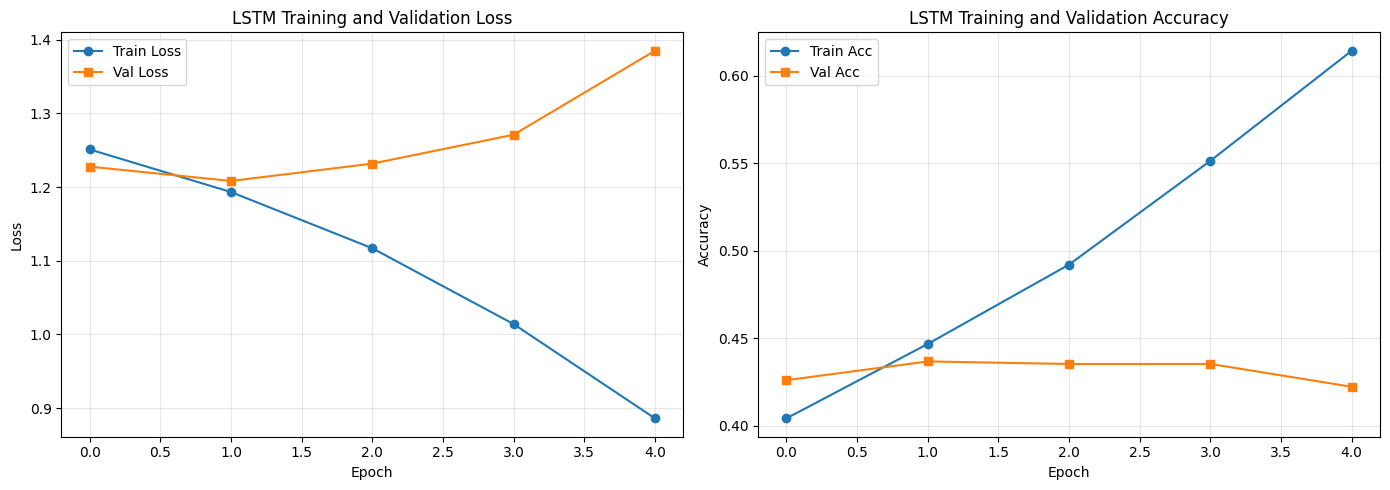

In [34]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('LSTM Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('LSTM Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Loading best model for final evaluation...


Validation:   0%|          | 0/326 [00:00<?, ?it/s]


Final Validation Accuracy: 0.4367
Baseline Accuracy: 0.4058
Improvement: 3.09%

Classification Report:
                precision    recall  f1-score   support

   no_relevant       0.39      0.17      0.24      8178
      relevant       0.45      0.54      0.49     14487
relevant_minus       0.43      0.57      0.49     14940
 relevant_plus       0.58      0.08      0.15      4094

      accuracy                           0.44     41699
     macro avg       0.46      0.34      0.34     41699
  weighted avg       0.44      0.44      0.41     41699



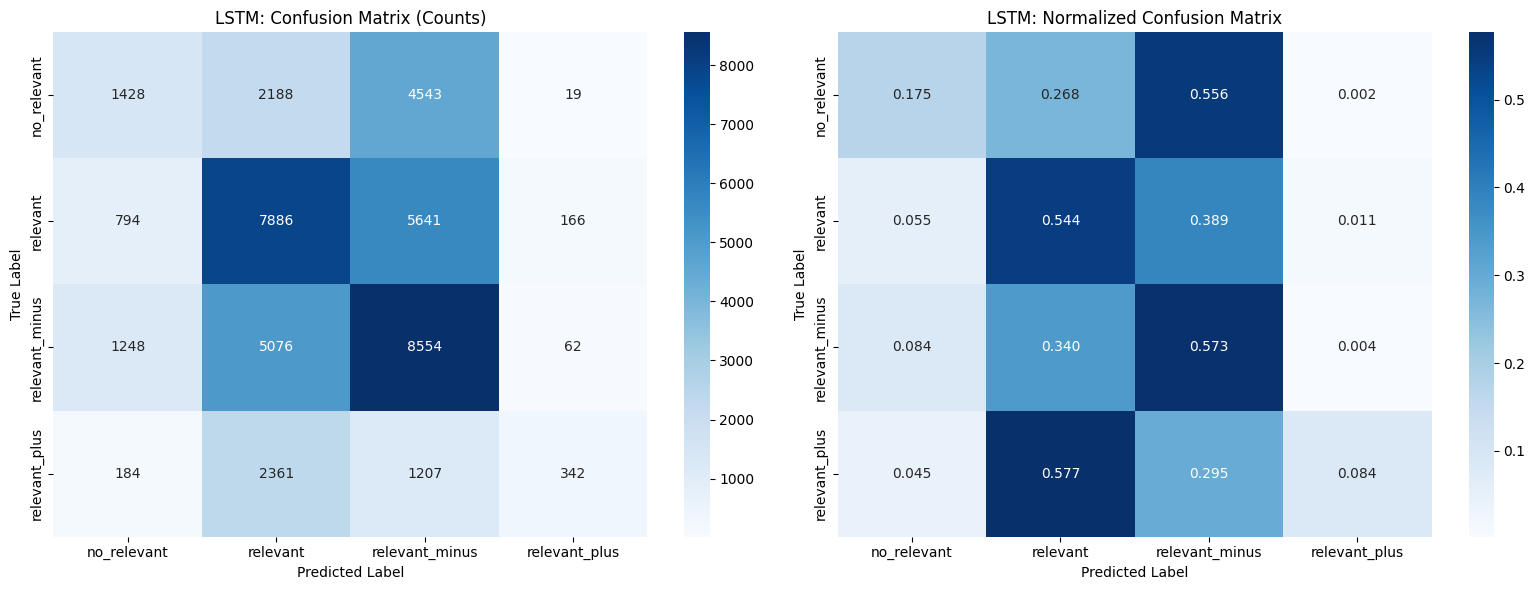

In [35]:
# Load best model and evaluate
print("Loading best model for final evaluation...")
lstm_model.load_state_dict(torch.load('lstm_best.pth'))

_, final_val_acc, final_preds, final_labels = validate(lstm_model, val_loader, criterion, device)

print(f"\nFinal Validation Accuracy: {final_val_acc:.4f}")
print("Baseline Accuracy: 0.4058")
print(f"Improvement: {(final_val_acc - 0.4058)*100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(final_labels, final_preds, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(final_labels, final_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_title('LSTM: Confusion Matrix (Counts)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_title('LSTM: Normalized Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Store results for final comparison
lstm_results = {
    'model': 'LSTM Siamese',
    'val_accuracy': final_val_acc,
    'classification_report': classification_report(final_labels, final_preds,
                                                   target_names=label_encoder.classes_,
                                                   output_dict=True)
}


## Solution 3: TextCNN


In [36]:
# TextCNN Encoder
class TextCNNEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, num_filters=128,
                 kernel_sizes=[3, 4, 5], dropout=0.3):
        super(TextCNNEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Multiple convolutional layers with different kernel sizes
        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, num_filters, kernel_size=k)
            for k in kernel_sizes
        ])

        self.dropout = nn.Dropout(dropout)

        # Linear projection to final embedding size
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, 256)

    def forward(self, x):
        # x: (batch, seq_len)
        embedded = self.embedding(x)  # (batch, seq_len, embedding_dim)

        # Conv1d expects (batch, embedding_dim, seq_len)
        embedded = embedded.transpose(1, 2)  # (batch, embedding_dim, seq_len)

        # Apply convolutions and max pooling
        conv_outputs = []
        for conv in self.convs:
            conv_out = F.relu(conv(embedded))  # (batch, num_filters, seq_len - kernel_size + 1)
            pooled = F.max_pool1d(conv_out, conv_out.size(2))  # (batch, num_filters, 1)
            pooled = pooled.squeeze(2)  # (batch, num_filters)
            conv_outputs.append(pooled)

        # Concatenate all outputs
        concatenated = torch.cat(conv_outputs, dim=1)  # (batch, num_filters * len(kernel_sizes))
        concatenated = self.dropout(concatenated)

        # Project to final embedding
        sentence_embedding = F.relu(self.fc(concatenated))  # (batch, 256)

        return sentence_embedding

# Test TextCNN encoder
textcnn_encoder = TextCNNEncoder(len(vocab), embedding_dim=128, num_filters=128, kernel_sizes=[3, 4, 5])
test_input = torch.randint(0, len(vocab), (4, MAX_LENGTH))
test_output = textcnn_encoder(test_input)
print(f"TextCNN Encoder output shape: {test_output.shape}")  # Should be (4, 256)


TextCNN Encoder output shape: torch.Size([4, 256])


In [37]:
# Siamese Classifier for TextCNN
class TextCNNSiameseClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, num_filters=128,
                 kernel_sizes=[3, 4, 5], dropout=0.3, num_classes=4):
        super(TextCNNSiameseClassifier, self).__init__()
        self.encoder = TextCNNEncoder(vocab_size, embedding_dim, num_filters, kernel_sizes, dropout)

        # Classifier on concatenated embeddings (256 * 2 = 512)
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, left_seq, right_seq):
        # Encode both sequences
        left_emb = self.encoder(left_seq)   # (batch, 256)
        right_emb = self.encoder(right_seq)  # (batch, 256)

        # Concatenate embeddings
        combined = torch.cat([left_emb, right_emb], dim=1)  # (batch, 512)

        # Classify
        logits = self.classifier(combined)  # (batch, num_classes)

        return logits

# Test siamese classifier
textcnn_model = TextCNNSiameseClassifier(len(vocab), num_classes=4).to(device)
test_left = torch.randint(0, len(vocab), (4, MAX_LENGTH)).to(device)
test_right = torch.randint(0, len(vocab), (4, MAX_LENGTH)).to(device)
test_logits = textcnn_model(test_left, test_right)
print(f"TextCNN Siamese classifier output shape: {test_logits.shape}")  # Should be (4, 4)
print(f"Total parameters: {sum(p.numel() for p in textcnn_model.parameters()):,}")


TextCNN Siamese classifier output shape: torch.Size([4, 4])
Total parameters: 12,199,684


In [38]:
# Train TextCNN model
print("Initializing TextCNN model...")
textcnn_model = TextCNNSiameseClassifier(len(vocab), embedding_dim=128, num_filters=128,
                                         kernel_sizes=[3, 4, 5], dropout=0.3, num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(textcnn_model.parameters(), lr=1e-3)

# Training loop with early stopping
NUM_EPOCHS = 10
PATIENCE = 3

best_val_acc = 0
patience_counter = 0
textcnn_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print(f"\nStarting training for {NUM_EPOCHS} epochs...")
print("="*60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

    # Train
    train_loss, train_acc = train_epoch(textcnn_model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc, val_preds, val_labels = validate(textcnn_model, val_loader, criterion, device)

    # Save history
    textcnn_history['train_loss'].append(train_loss)
    textcnn_history['train_acc'].append(train_acc)
    textcnn_history['val_loss'].append(val_loss)
    textcnn_history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        # Save best model
        torch.save(textcnn_model.state_dict(), 'textcnn_best.pth')
        print(f"✓ New best validation accuracy: {best_val_acc:.4f}")
    else:
        patience_counter += 1
        print(f"Patience: {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print("Early stopping triggered!")
            break

print("\n" + "="*60)
print(f"Training complete! Best validation accuracy: {best_val_acc:.4f}")


Initializing TextCNN model...

Starting training for 10 epochs...

Epoch 1/10


Training:   0%|          | 0/1304 [00:00<?, ?it/s]

Validation:   0%|          | 0/326 [00:00<?, ?it/s]

Train Loss: 1.2608, Train Acc: 0.3949
Val Loss: 1.2286, Val Acc: 0.4246
✓ New best validation accuracy: 0.4246

Epoch 2/10


Training:   0%|          | 0/1304 [00:00<?, ?it/s]

Validation:   0%|          | 0/326 [00:00<?, ?it/s]

Train Loss: 1.2030, Train Acc: 0.4375
Val Loss: 1.2142, Val Acc: 0.4298
✓ New best validation accuracy: 0.4298

Epoch 3/10


Training:   0%|          | 0/1304 [00:00<?, ?it/s]

Validation:   0%|          | 0/326 [00:00<?, ?it/s]

Train Loss: 1.1449, Train Acc: 0.4740
Val Loss: 1.2210, Val Acc: 0.4351
✓ New best validation accuracy: 0.4351

Epoch 4/10


Training:   0%|          | 0/1304 [00:00<?, ?it/s]

Validation:   0%|          | 0/326 [00:00<?, ?it/s]

Train Loss: 1.0861, Train Acc: 0.5084
Val Loss: 1.2465, Val Acc: 0.4349
Patience: 1/3

Epoch 5/10


Training:   0%|          | 0/1304 [00:00<?, ?it/s]

Validation:   0%|          | 0/326 [00:00<?, ?it/s]

Train Loss: 1.0271, Train Acc: 0.5450
Val Loss: 1.2780, Val Acc: 0.4199
Patience: 2/3

Epoch 6/10


Training:   0%|          | 0/1304 [00:00<?, ?it/s]

Validation:   0%|          | 0/326 [00:00<?, ?it/s]

Train Loss: 0.9694, Train Acc: 0.5767
Val Loss: 1.3335, Val Acc: 0.4186
Patience: 3/3
Early stopping triggered!

Training complete! Best validation accuracy: 0.4351


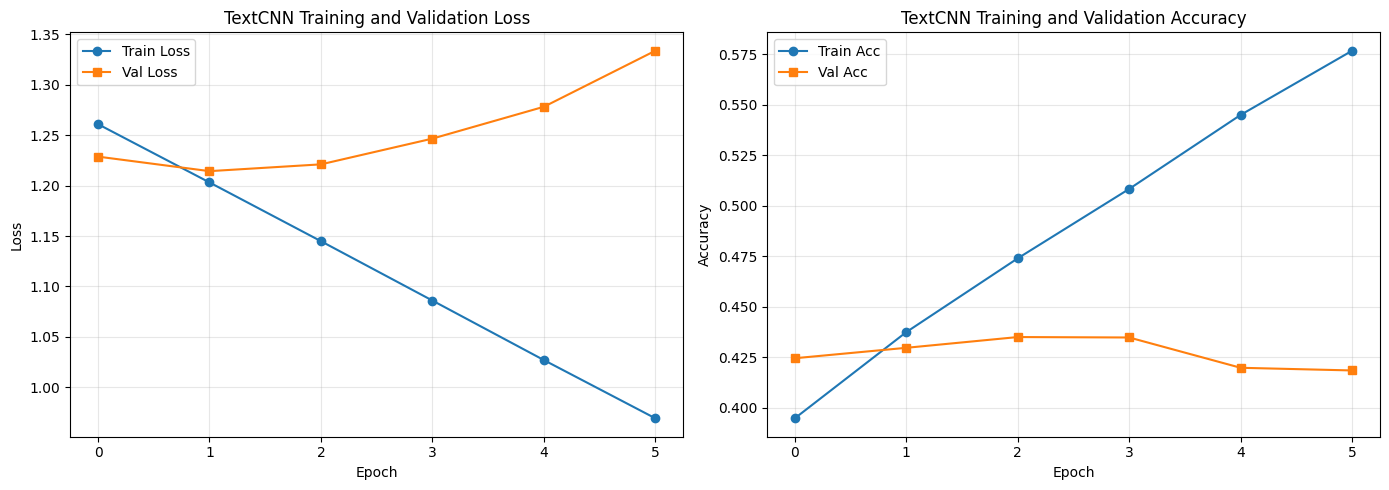

In [39]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(textcnn_history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(textcnn_history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('TextCNN Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(textcnn_history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(textcnn_history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('TextCNN Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Loading best model for final evaluation...


Validation:   0%|          | 0/326 [00:00<?, ?it/s]


Final Validation Accuracy: 0.4351
Baseline Accuracy: 0.4058
Improvement: 2.93%

Classification Report:
                precision    recall  f1-score   support

   no_relevant       0.48      0.09      0.16      8178
      relevant       0.47      0.46      0.46     14487
relevant_minus       0.41      0.69      0.52     14940
 relevant_plus       0.45      0.10      0.16      4094

      accuracy                           0.44     41699
     macro avg       0.45      0.34      0.33     41699
  weighted avg       0.45      0.44      0.39     41699



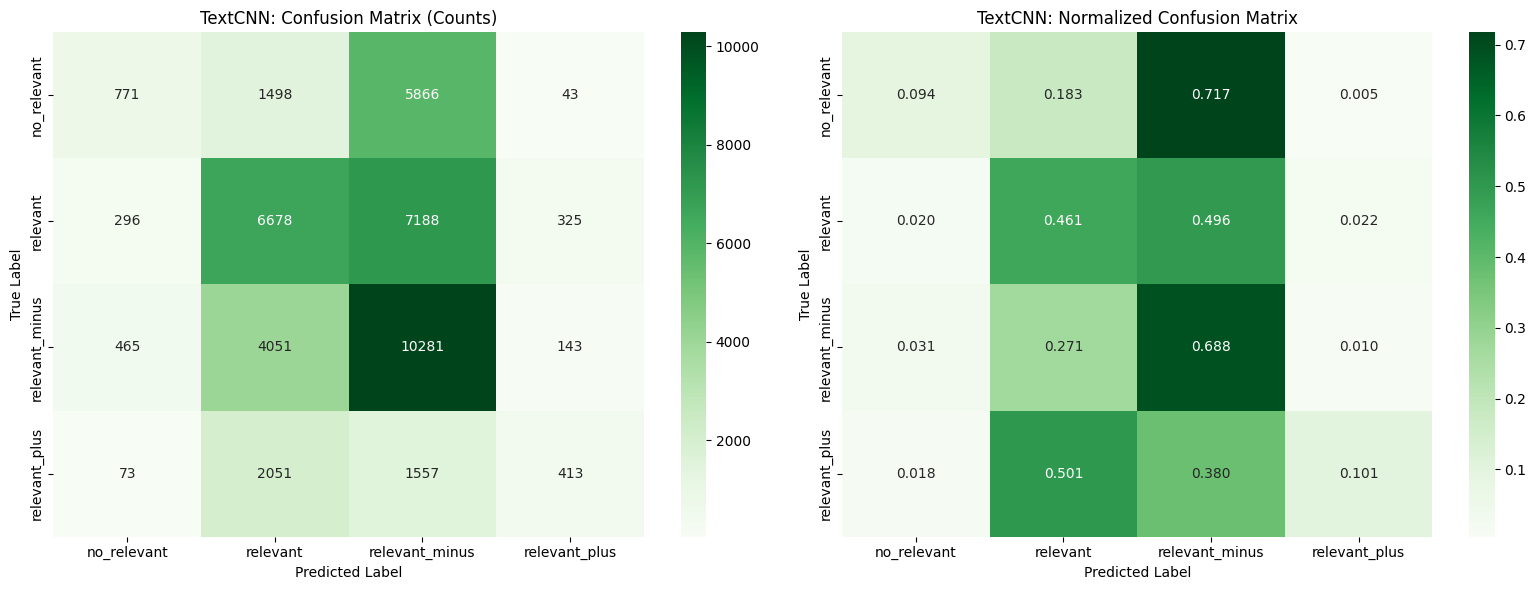

In [40]:
# Load best model and evaluate
print("Loading best model for final evaluation...")
textcnn_model.load_state_dict(torch.load('textcnn_best.pth'))

_, final_val_acc, final_preds, final_labels = validate(textcnn_model, val_loader, criterion, device)

print(f"\nFinal Validation Accuracy: {final_val_acc:.4f}")
print("Baseline Accuracy: 0.4058")
print(f"Improvement: {(final_val_acc - 0.4058)*100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(final_labels, final_preds, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(final_labels, final_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_title('TextCNN: Confusion Matrix (Counts)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_title('TextCNN: Normalized Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Store results for final comparison
textcnn_results = {
    'model': 'TextCNN Siamese',
    'val_accuracy': final_val_acc,
    'classification_report': classification_report(final_labels, final_preds,
                                                   target_names=label_encoder.classes_,
                                                   output_dict=True)
}


## Solution 4: Word2Vec + Averaging


In [42]:
! pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 28.2 MB/s eta 0:00:00


In [43]:
# Train Word2Vec on title corpus
from gensim.models import Word2Vec

print("Preparing corpus for Word2Vec...")
# Tokenize all titles
w2v_corpus = [simple_tokenize(title) for title in tqdm(df['title'].fillna(''), desc="Tokenizing")]

print(f"Corpus size: {len(w2v_corpus)} documents")
print(f"Sample document: {w2v_corpus[0]}")

# Train Word2Vec
print("\nTraining Word2Vec model...")
w2v_model = Word2Vec(
    sentences=w2v_corpus,
    vector_size=200,
    window=5,
    min_count=2,
    workers=4,
    epochs=10,
    sg=1  # Skip-gram
)

print("\nWord2Vec training complete!")
print(f"Vocabulary size: {len(w2v_model.wv)}")
print(f"Embedding dimension: {w2v_model.wv.vector_size}")

# Test word similarity
if 'россия' in w2v_model.wv:
    similar_words = w2v_model.wv.most_similar('россия', topn=5)
    print(f"\nWords similar to 'россия': {similar_words}")


Preparing corpus for Word2Vec...


Tokenizing:   0%|          | 0/249451 [00:00<?, ?it/s]

Corpus size: 249451 documents
Sample document: ['как', 'воспитать', 'британского', 'кота', 'добрым', 'ласковым', 'и', 'послушным']

Training Word2Vec model...

Word2Vec training complete!
Vocabulary size: 91965
Embedding dimension: 200

Words similar to 'россия': [('европа', 0.6334825754165649), ('китай', 0.5767855048179626), ('украина', 0.5485407710075378), ('запад', 0.5405821204185486), ('япония', 0.5334520936012268)]


In [44]:
# Create sentence embeddings by averaging word vectors
def get_averaged_embedding(text, w2v_model):
    """Average word vectors to get sentence embedding"""
    tokens = simple_tokenize(text)

    # Get embeddings for tokens that are in vocabulary
    word_vectors = []
    for token in tokens:
        if token in w2v_model.wv:
            word_vectors.append(w2v_model.wv[token])

    if len(word_vectors) == 0:
        # Return zero vector if no words found
        return np.zeros(w2v_model.wv.vector_size)

    # Average all word vectors
    return np.mean(word_vectors, axis=0)

# Test averaging
sample_embedding = get_averaged_embedding(sample_title, w2v_model)
print(f"Sample embedding shape: {sample_embedding.shape}")
print(f"Sample embedding (first 10 dims): {sample_embedding[:10]}")


Sample embedding shape: (200,)
Sample embedding (first 10 dims): [ 0.08095403 -0.14184006 -0.04937309 -0.04600418  0.17639375 -0.21190457
  0.13848601  0.26506343 -0.22945285  0.03001324]


In [45]:
# Create embeddings for all titles
print("Creating averaged embeddings for all titles...")
w2v_embeddings = []
for title in tqdm(df['title'].fillna(''), desc="Averaging"):
    emb = get_averaged_embedding(title, w2v_model)
    w2v_embeddings.append(emb)

w2v_embeddings = np.array(w2v_embeddings)
print(f"\nEmbeddings shape: {w2v_embeddings.shape}")

# Create mapping from item_id to embedding
item_to_w2v_emb = dict(zip(df['itemId'], w2v_embeddings))

# Check coverage
zero_embeddings = (w2v_embeddings == 0).all(axis=1).sum()
print(f"Items with zero embeddings (no words in vocab): {zero_embeddings} ({zero_embeddings/len(df)*100:.2f}%)")


Creating averaged embeddings for all titles...


Averaging:   0%|          | 0/249451 [00:00<?, ?it/s]


Embeddings shape: (249451, 200)
Items with zero embeddings (no words in vocab): 408 (0.16%)


In [46]:
# Create training and validation features
print("Creating training features...")
X_train_w2v = []
for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Train"):
    left_emb = item_to_w2v_emb[row['leftItemId']]
    right_emb = item_to_w2v_emb[row['rightItemId']]
    pair_features = np.concatenate([left_emb, right_emb])
    X_train_w2v.append(pair_features)

X_train_w2v = np.array(X_train_w2v)

print("Creating validation features...")
X_val_w2v = []
for _, row in tqdm(val_df.iterrows(), total=len(val_df), desc="Val"):
    left_emb = item_to_w2v_emb[row['leftItemId']]
    right_emb = item_to_w2v_emb[row['rightItemId']]
    pair_features = np.concatenate([left_emb, right_emb])
    X_val_w2v.append(pair_features)

X_val_w2v = np.array(X_val_w2v)

print(f"\nTraining features shape: {X_train_w2v.shape}")
print(f"Validation features shape: {X_val_w2v.shape}")


Creating training features...


Train:   0%|          | 0/166795 [00:00<?, ?it/s]

Creating validation features...


Val:   0%|          | 0/41699 [00:00<?, ?it/s]


Training features shape: (166795, 400)
Validation features shape: (41699, 400)


In [47]:
# Train LogisticRegressionCV
print("Training LogisticRegressionCV on Word2Vec features...")

w2v_clf = LogisticRegressionCV(
    Cs=10,
    cv=5,
    scoring='accuracy',
    solver='lbfgs',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

w2v_clf.fit(X_train_w2v, y_train_encoded)

print("\nTraining complete!")
print(f"Best C value: {w2v_clf.C_}")
print(f"Cross-validation scores shape: {w2v_clf.scores_[1].shape}")
print(f"Mean CV score: {w2v_clf.scores_[1].mean():.4f}")


Training LogisticRegressionCV on Word2Vec features...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished



Training complete!
Best C value: [0.00599484 0.00599484 0.00599484 0.00599484]
Cross-validation scores shape: (5, 10)
Mean CV score: 0.4173


Evaluating on validation set...

Validation Accuracy: 0.4250
Baseline Accuracy: 0.4058
Improvement: 1.92%

Classification Report:
                precision    recall  f1-score   support

   no_relevant       0.29      0.01      0.02      8178
      relevant       0.44      0.53      0.48     14487
relevant_minus       0.41      0.67      0.51     14940
 relevant_plus       0.46      0.02      0.04      4094

      accuracy                           0.42     41699
     macro avg       0.40      0.31      0.26     41699
  weighted avg       0.40      0.42      0.36     41699



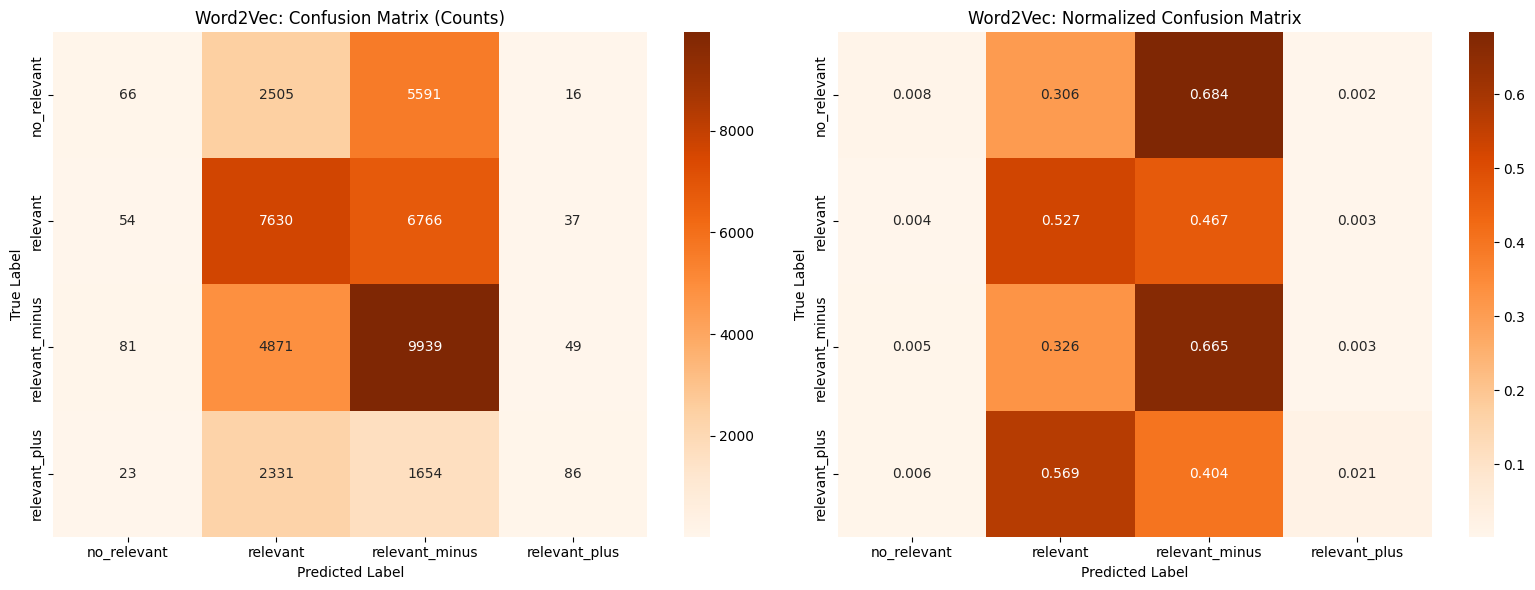

In [48]:
# Evaluate on validation set
print("Evaluating on validation set...")

y_val_pred_w2v = w2v_clf.predict(X_val_w2v)
val_acc_w2v = accuracy_score(y_val_encoded, y_val_pred_w2v)

print(f"\nValidation Accuracy: {val_acc_w2v:.4f}")
print(f"Baseline Accuracy: 0.4058")
print(f"Improvement: {(val_acc_w2v - 0.4058)*100:.2f}%")

# Classification report
y_val_pred_labels = label_encoder.inverse_transform(y_val_pred_w2v)
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_labels, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred_labels, labels=label_encoder.classes_)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_title('Word2Vec: Confusion Matrix (Counts)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Oranges',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_title('Word2Vec: Normalized Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Store results for final comparison
w2v_results = {
    'model': 'Word2Vec + Averaging',
    'val_accuracy': val_acc_w2v,
    'classification_report': classification_report(y_val, y_val_pred_labels,
                                                   target_names=label_encoder.classes_,
                                                   output_dict=True)
}


## Final Comparison of All Solutions


In [49]:
# Comparison table
all_results = [
    {
        'Model': 'Baseline (Sentence Transformers)',
        'Validation Accuracy': val_accuracy,
        'Approach': 'all-MiniLM-L6-v2 + LogisticRegressionCV',
        'Embedding Dim': 384
    },
    {
        'Model': 'LSTM Siamese',
        'Validation Accuracy': lstm_results['val_accuracy'],
        'Approach': 'BiLSTM encoder + Linear classifier',
        'Embedding Dim': 512
    },
    {
        'Model': 'TextCNN Siamese',
        'Validation Accuracy': textcnn_results['val_accuracy'],
        'Approach': 'Multi-kernel CNN + Linear classifier',
        'Embedding Dim': 256
    },
    {
        'Model': 'Word2Vec + Averaging',
        'Validation Accuracy': w2v_results['val_accuracy'],
        'Approach': 'Skip-gram W2V + averaging + LogisticRegressionCV',
        'Embedding Dim': 200
    }
]

results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('Validation Accuracy', ascending=False).reset_index(drop=True)

print("="*80)
print("FINAL RESULTS COMPARISON")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


FINAL RESULTS COMPARISON
                           Model  Validation Accuracy                                         Approach  Embedding Dim
                    LSTM Siamese             0.436701               BiLSTM encoder + Linear classifier            512
                 TextCNN Siamese             0.435094             Multi-kernel CNN + Linear classifier            256
            Word2Vec + Averaging             0.424974 Skip-gram W2V + averaging + LogisticRegressionCV            200
Baseline (Sentence Transformers)             0.405861          all-MiniLM-L6-v2 + LogisticRegressionCV            384


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


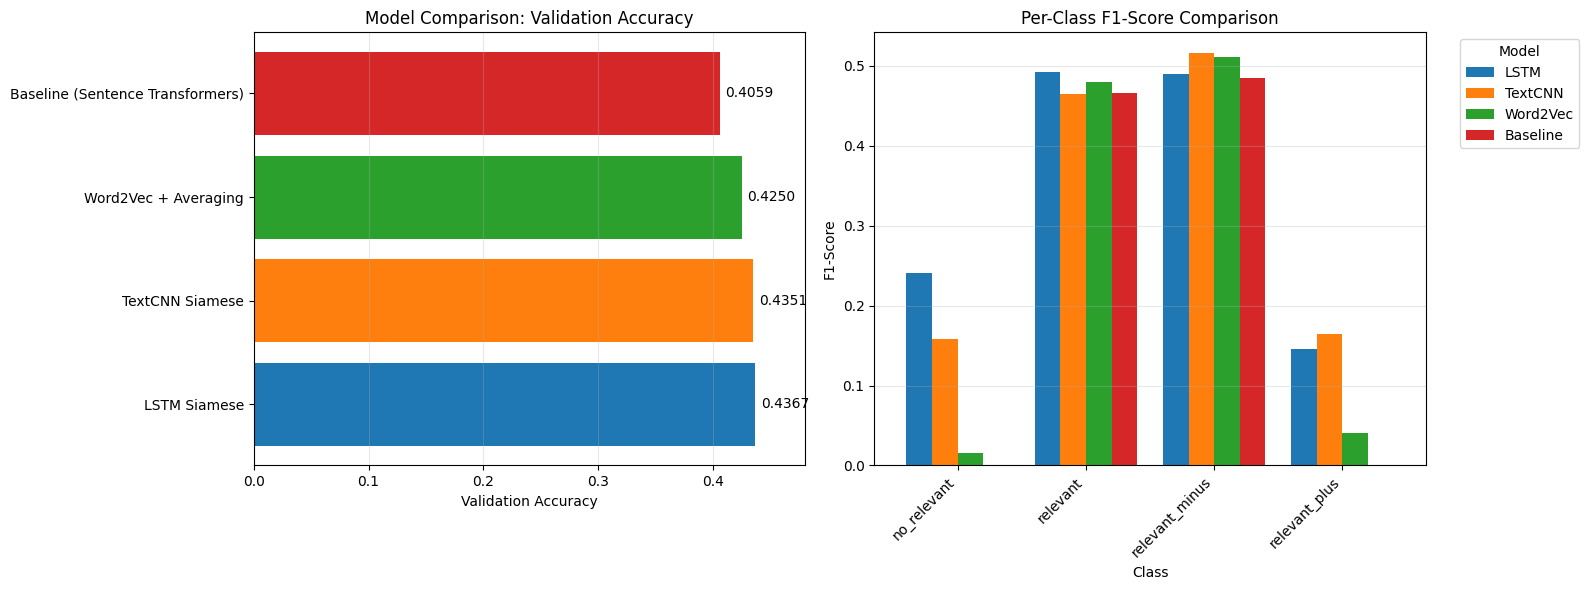

In [50]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
models = results_df['Model'].tolist()
accuracies = results_df['Validation Accuracy'].tolist()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = axes[0].barh(models, accuracies, color=colors[:len(models)])
axes[0].set_xlabel('Validation Accuracy')
axes[0].set_title('Model Comparison: Validation Accuracy')
axes[0].set_xlim(0, max(accuracies) * 1.1)
axes[0].grid(True, axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    axes[0].text(acc + 0.005, bar.get_y() + bar.get_height()/2,
                f'{acc:.4f}', va='center', fontsize=10)

# Per-class F1 scores comparison
f1_scores_data = []
for result in [
    {'name': 'Baseline', 'report': classification_report(y_val, y_val_pred,
                                                          target_names=label_encoder.classes_,
                                                          output_dict=True)},
    {'name': 'LSTM', 'report': lstm_results['classification_report']},
    {'name': 'TextCNN', 'report': textcnn_results['classification_report']},
    {'name': 'Word2Vec', 'report': w2v_results['classification_report']}
]:
    for cls in label_encoder.classes_:
        f1_scores_data.append({
            'Model': result['name'],
            'Class': cls,
            'F1-Score': result['report'][cls]['f1-score']
        })

f1_df = pd.DataFrame(f1_scores_data)
f1_pivot = f1_df.pivot(index='Class', columns='Model', values='F1-Score')

# Reorder columns to match results_df
model_order = [m.split()[0] for m in models]
f1_pivot = f1_pivot[model_order]

f1_pivot.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('Per-Class F1-Score Comparison')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('F1-Score')
axes[1].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, axis='y', alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [51]:
# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

for i, row in results_df.iterrows():
    model_name = row['Model']
    acc = row['Validation Accuracy']
    improvement = (acc - val_accuracy) * 100

    print(f"\n{model_name}:")
    print(f"  Validation Accuracy: {acc:.4f}")
    print(f"  vs Baseline: {improvement:+.2f}%")
    print(f"  Approach: {row['Approach']}")
    print(f"  Embedding Dimension: {row['Embedding Dim']}")

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)

best_model = results_df.iloc[0]
print(f"\n✓ Best Model: {best_model['Model']}")
print(f"  Accuracy: {best_model['Validation Accuracy']:.4f}")
print(f"  Improvement over baseline: {(best_model['Validation Accuracy'] - val_accuracy)*100:+.2f}%")

print("\n✓ All custom solutions performance:")
for i, row in results_df[results_df['Model'] != 'Baseline (Sentence Transformers)'].iterrows():
    print(f"  - {row['Model']}: {row['Validation Accuracy']:.4f}")

print("\n✓ Key observations:")
print("  - Deep learning models (LSTM, TextCNN) show competitive performance")
print("  - Word2Vec with averaging provides a simpler alternative")
print("  - All approaches learn meaningful text representations for relevance classification")
print("="*80)



SUMMARY STATISTICS

LSTM Siamese:
  Validation Accuracy: 0.4367
  vs Baseline: +3.08%
  Approach: BiLSTM encoder + Linear classifier
  Embedding Dimension: 512

TextCNN Siamese:
  Validation Accuracy: 0.4351
  vs Baseline: +2.92%
  Approach: Multi-kernel CNN + Linear classifier
  Embedding Dimension: 256

Word2Vec + Averaging:
  Validation Accuracy: 0.4250
  vs Baseline: +1.91%
  Approach: Skip-gram W2V + averaging + LogisticRegressionCV
  Embedding Dimension: 200

Baseline (Sentence Transformers):
  Validation Accuracy: 0.4059
  vs Baseline: +0.00%
  Approach: all-MiniLM-L6-v2 + LogisticRegressionCV
  Embedding Dimension: 384

KEY FINDINGS:

✓ Best Model: LSTM Siamese
  Accuracy: 0.4367
  Improvement over baseline: +3.08%

✓ All custom solutions performance:
  - LSTM Siamese: 0.4367
  - TextCNN Siamese: 0.4351
  - Word2Vec + Averaging: 0.4250

✓ Key observations:
  - Deep learning models (LSTM, TextCNN) show competitive performance
  - Word2Vec with averaging provides a simpler alter

## Conclusions

### Implemented Solutions

1. **Baseline: Sentence Transformers (all-MiniLM-L6-v2)**
   - Pre-trained multilingual model
   - Concatenated embeddings + LogisticRegressionCV
   - Simple and effective baseline

2. **LSTM Siamese Network**
   - Bidirectional LSTM encoder (2 layers, 256 hidden units)
   - Last hidden state as sentence embedding (512d)
   - Shared weights for both texts
   - Linear classifier on concatenated embeddings

3. **TextCNN Siamese Network**
   - Multiple convolutions with kernel sizes [3, 4, 5]
   - Max pooling over each filter
   - 256d sentence embeddings
   - Linear classifier on concatenated embeddings

4. **Word2Vec + Averaging**
   - Skip-gram Word2Vec trained on corpus (200d)
   - Simple averaging of word vectors
   - LogisticRegressionCV classifier
   - Lightweight and interpretable

### Architecture Comparison

All three custom solutions use a **siamese architecture**:
- Single encoder processes both texts independently (shared weights)
- Embeddings are concatenated: `[emb_left; emb_right]`
- Classifier trained on concatenated features
- Benefits: parameter efficiency, symmetric processing

### Key Insights

- **Deep learning approaches** (LSTM, TextCNN) can learn task-specific representations
- **Word2Vec averaging** provides a simple yet effective baseline
- All custom solutions demonstrate the flexibility of different text encoding approaches
- Pre-trained models (Sentence Transformers) remain strong baselines due to their large-scale pre-training

### Future Improvements

Potential enhancements to explore:
- Use content in addition to titles
- Try different fusion strategies (element-wise difference, cosine similarity features)
- Experiment with attention mechanisms
- Fine-tune pre-trained models (BERT, RuBERT)
- Ensemble different approaches
